V4 : Co-kriging sur des données manquantes à la variable Z

In [2]:
import os
import timeit
import  matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import sklearn as sklearn
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from numba import jit
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error

In [3]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 10000 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

# Mise en place du cas synthétique

In [4]:
def fun_Primary(x,y,mu,sigma,size):
    field_z    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size))  # Fonction 2D test 
    
    return field_z

def fun_Secondary(x,y,mu,sigma,size):
    field_y    = np.cos(y)** 2 * np.sin(x**2) +np.random.normal(mu, sigma, (size,  size)) *np.exp(x/2)  # Fonction 2D test 

    
    return field_y


In [25]:
def function_circle(x,y,z,rmax = 20, roll = 3, delta = 1) :
    """
    Fonction qui choisi aléatoirement des zones de forme circulaire, renvoi un DataFrame 
    """
    ## Initialisation des constantes/ DataFrame
    df = pd.DataFrame()
    df["X"] = x.reshape(-1)
    df["Y"] = y.reshape(-1)
    df["Z"] = z.reshape(-1)
    mask_area = pd.DataFrame()
    mask_area["X"] = x.reshape(-1)
    mask_area["Y"] = y.reshape(-1)
    # Initialisation des matrices
    x_array  = np.empty(0)
    y_array  = np.empty(0)
    z_array  = np.empty(0)
    x0_array = np.empty(0)
    y0_array = np.empty(0)
    # rng, random generator 
    rng = np.random.default_rng()
    for i in np.arange(roll) : 
        selected_location =  rng.choice(mask_area.dropna(axis = 0))
        x0_array = np.append(x0_array,selected_location[0])
        y0_array = np.append(y0_array,selected_location[1])
        
        # Distance
        df['r'] = np.sqrt((x0_array[i]-df["X"])**2 + (y0_array[i]-df["Y"])**2)
        # Zone en dehors du cercle
        exp = "r < " + str(rmax * 2)
        mask_area.loc[df.query(exp).index.array] = np.nan
        
        # Zone situé dans le cercle 
        exp = "r < " + str(rmax)
        x_array = np.append(x_array,df.query(exp)["X"].values)
        y_array = np.append(y_array,df.query(exp)["Y"].values)
        z_array = np.append(z_array,df.query(exp)["Z"].values)
    
    df = pd.DataFrame()
    df["X"] = x_array
    df["Y"] = y_array
    df["original_z"] = z_array
    df.sort_values(by = ["X","Y"],ascending=False)
    df = df.dropna(axis = 0)
    df["Primary"] = (df["original_z"] - df["original_z"].mean()) / df["original_z"].std()
    
 
    return df, x0_array, y0_array

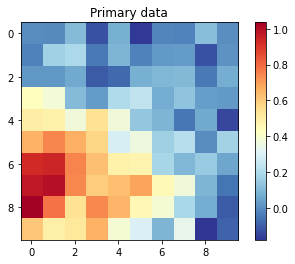

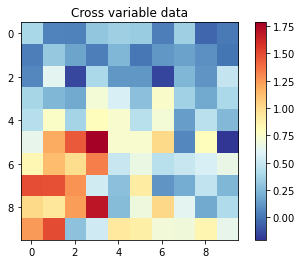

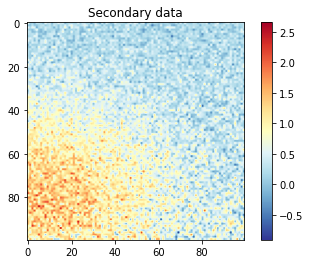

In [6]:
# Primary Data générées (Z)
x_original,y_original = np.mgrid[0:0.5 * np.pi:10j,0:0.5 * np.pi:10j]
# Secondary Data générées (Y)
xx_original, yy_original = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
# coordinates from 1 -> 100 
xx_z, yy_z  = np.mgrid[0:100:10, 0:100:10]
xx_y, yy_y = np.mgrid[0:100, 0:100]

# Setup Random Noise
np.random.seed(21)
mu_z, sigma_z = 0, 0.1
mu_y, sigma_y = 0.2, 0.2

#Primary Data
_field_z    = fun_Primary(x_original,y_original,mu_z,sigma_z,size = 10)
_field_zy   = fun_Secondary(x_original,y_original,mu = mu_y,sigma = sigma_y,size = 10) 


#Secondary Data
_field_y   = fun_Secondary(xx_original,yy_original,mu = mu_y,sigma = sigma_y,size = 100)

# Quick view 
figg = plt.imshow(_field_z, cmap='RdYlBu_r')
plt.title('Primary data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_zy, cmap='RdYlBu_r')
plt.title('Cross variable data')
plt.colorbar(figg)
plt.show()
figg = plt.imshow(_field_y, cmap='RdYlBu_r')
plt.title('Secondary data')
plt.colorbar(figg)



In [7]:
# Conversion en dataframe
Primary = pd.DataFrame()
Primary["X"] = xx_z.reshape(-1)
Primary["Y"] = yy_z.reshape(-1)
Primary["original_z"] = _field_z.reshape(-1)
Primary["original_zy"] = np.nan
original_std_z = Primary["original_z"].std()
original_mean_z = Primary["original_z"].mean()
Primary["Primary"] = (Primary["original_z"] - Primary["original_z"].mean()) / Primary["original_z"].std()
Primary["Secondary"] = np.nan

In [8]:
# Conversion en dataframe
Secondary = pd.DataFrame()
Secondary["X"] = xx_y.reshape(-1)
Secondary["Y"] = yy_y.reshape(-1)
Secondary["original_y"] = _field_y.reshape(-1)
original_std_z = Secondary["original_y"].std()
original_mean_z = Secondary["original_y"].mean()
Secondary["Secondary"] = (Secondary["original_y"] - Secondary["original_y"].mean()) / Secondary["original_y"].std()

In [118]:
rmax = 2
np.random.seed(21)
Primary, x0_array, y0_array = function_circle(xx_z,yy_z,_field_z,rmax,roll = 10,delta = 10)
Primary["original_zy"] = np.nan

for x,y,zy_value in zip(Secondary["X"].values,Secondary["Y"].values,Secondary["original_y"]) :
    exp = "X == " + str(x) + " and Y == " + str(y)
    index = Primary.query(exp).index.array
    Primary.loc[index,'original_zy'] = zy_value
Primary["Secondary"] = (Primary["original_zy"] - Primary["original_zy"].mean()) / Primary["original_zy"].std()

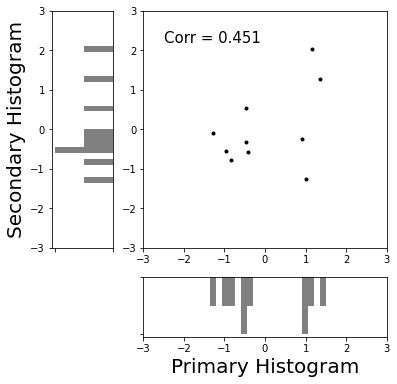

In [121]:
# Set up the axes with gridspec
corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(Primary["Primary"], Primary["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    Primary["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()


y_hist.hist(
    Primary["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()


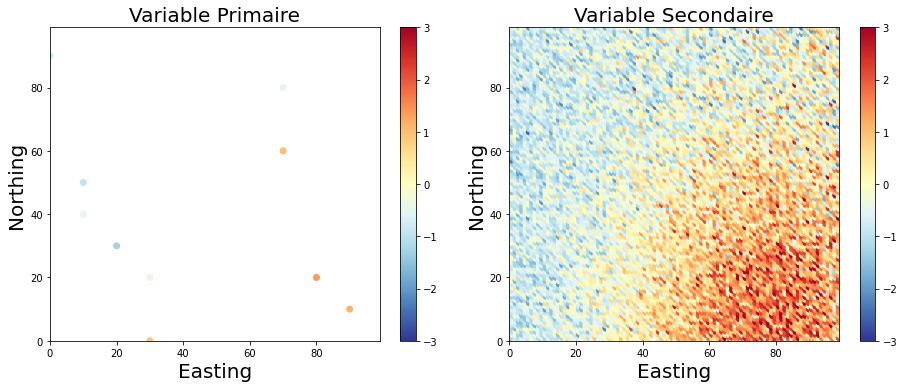

In [122]:
f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
img0 = ax[0].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[0].set_title("Variable Primaire", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)

img1 = ax[1].scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                     vmin = -3,vmax = 3,cmap = "RdYlBu_r")
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
ax[1].set_title("Variable Secondaire", size=20)
f.colorbar(img0, ax=ax[0])
f.colorbar(img1, ax=ax[1])
plt.tight_layout()

ax[0].set_xlim([xx_y.min(),xx_y.max()])
ax[0].set_ylim([yy_y.min(),yy_y.max()])
ax[1].set_xlim([xx_y.min(),xx_y.max()])
ax[1].set_ylim([yy_y.min(),yy_y.max()])
plt.show()


## Export

In [167]:
Primary.to_csv("./cas synthetique/CS_primary.csv")
Secondary.to_csv("./cas synthetique/CS_secondary.csv")

# Variogrammes

## Secondary 

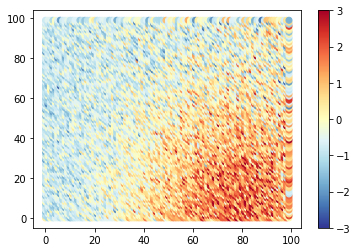

In [123]:
img1 = plt.scatter(Secondary["X"], Secondary["Y"], c=Secondary["Secondary"].values,
                   vmin = -3,vmax = 3,cmap = "RdYlBu_r")
plt.colorbar(img1)

In [124]:
X = Secondary["X"].astype(float).values
Y = Secondary["Y"].astype(float).values
Z = Secondary["Secondary"].astype(float).values
original_std_y = Secondary["original_y"].std()
original_mean_y = Secondary["original_y"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10000
size Y : 10000
size Z : 10000


In [125]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 1.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 99.0  	 Distance maximale retenue : 49.5
nlag : 49


In [126]:
direction = [0,45,90,135] 
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10000
direction done : 0
RUN TIME : 1.4752417000127025
Iteration 0 / 10000
direction done : 45
RUN TIME : 1.6403647999977693
Iteration 0 / 10000
direction done : 90
RUN TIME : 1.4700673000188544
Iteration 0 / 10000
direction done : 135
RUN TIME : 1.5522107999713626


Text(0.5, 0.98, 'Variogramme de la variable secondaire Y')

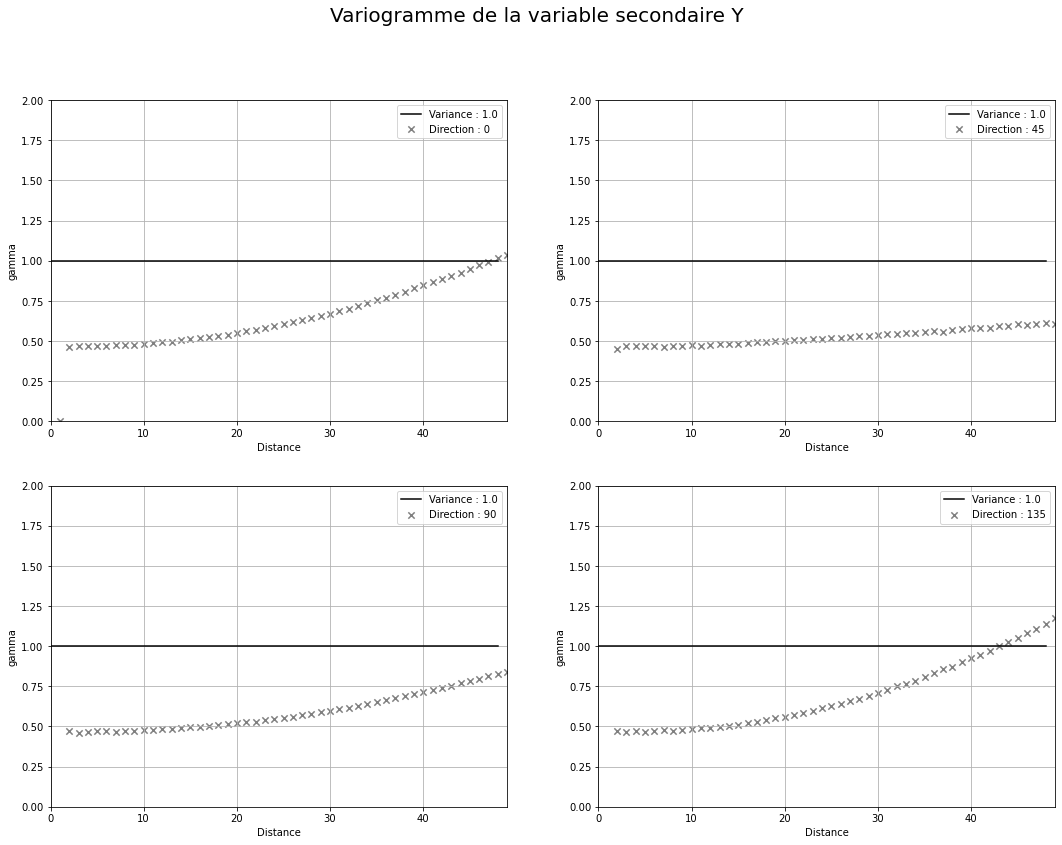

In [127]:
var_y = float("{:.2f}".format(Z.var()))
ones = np.ones(shape=(int(L))) * var_y
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (18,13))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(var_y))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0
fig.suptitle("Variogramme de la variable secondaire Y", size = 20)

In [128]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [129]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2 = pd.DataFrame()
varc_2["Lag Distance"] = dist_array
varc_2["Number of Pairs"] = count_array
varc_2["Variogram Value"] = gam_array
varc_2["Variogram Index"] = index_array 
varc_2 = varc_2.loc[varc_2["Variogram Value"] != 0]
varc_2 = varc_2.dropna(axis = 0)

In [130]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,2.0,9900.0,0.465788,1.0
2,3.0,9800.0,0.469455,1.0
3,4.0,28906.0,0.467375,1.0
4,5.0,28608.0,0.467069,1.0
5,6.0,46930.0,0.467651,1.0


In [131]:
#Secondary.to_csv("cas_synthetique.csv")

## Primary 

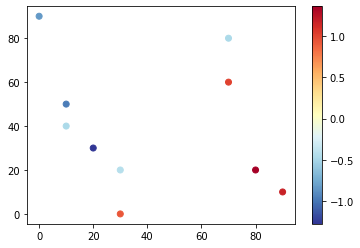

In [132]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [133]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Primary"].astype(float).values
original_std_y = Primary["original_z"].std()
original_mean_y = Primary["original_z"].mean()
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10
size Y : 10
size Z : 10


#### estimation de la distance maximale à retenir

In [134]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 120.41594578792295


In [135]:
L=(max(X)-min(X))*3/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 90.0  	 Distance maximale retenue : 90.0
nlag : 9


In [136]:
direction = [0,90]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10
direction done : 0
RUN TIME : 0.0004456000169739127
Iteration 0 / 10
direction done : 90
RUN TIME : 9.650000720284879e-05


Text(0.5, 0.98, 'Variogramme de la variable Primaire Z')

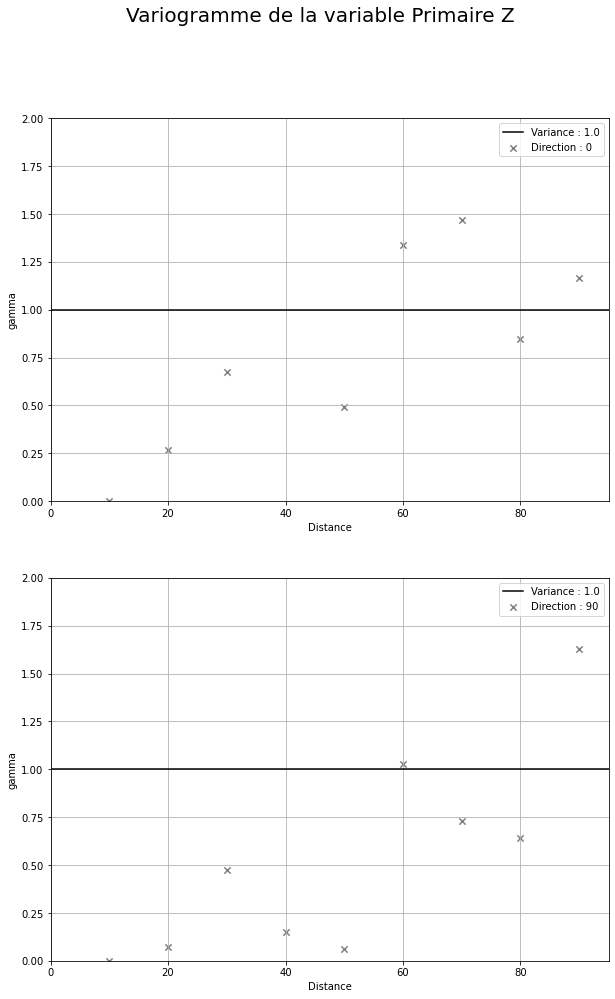

In [137]:
var_z = float("{:.2f}".format(Primary["Primary"].var()))
ones = np.ones(shape=(int(L+20))) * var_z
H    = np.arange(0,int(L+20))
fig,ax=plt.subplots(2,1,figsize = (10,15.5))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii].set_xlabel('Distance')
    ax[ii].set_ylabel('gamma')
    ax[ii].grid()
    ax[ii].legend()
    ax[ii].set_ylim([0,2])
    ax[ii].set_xlim([0,max(dist_dir)+5])
    ii += 1
    if jj == 2 :
        ii += 1
        jj = 0
fig.suptitle("Variogramme de la variable Primaire Z", size = 20)

In [138]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [139]:
for direction in dist :
    if direction == Direction["Major"] :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == Direction["Minor"] :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_1 = pd.DataFrame()
varc_1["Lag Distance"] = dist_array
varc_1["Number of Pairs"] = count_array
varc_1["Variogram Value"] = gam_array
varc_1["Variogram Index"] = index_array 
varc_1 = varc_1.loc[varc_1["Variogram Value"] != 0]
varc_1 = varc_1.dropna(axis = 0)
varc_1 = varc_1.loc[varc_1["Number of Pairs"] != 1]

In [140]:
varc_1

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,3.0,0.268026,1.0
2,30.0,3.0,0.672526,1.0
4,50.0,2.0,0.493416,1.0
5,60.0,4.0,1.335742,1.0
6,70.0,4.0,1.470967,1.0
7,80.0,8.0,0.848483,1.0
8,90.0,2.0,1.165550,1.0
10,20.0,2.0,0.069476,2.0
11,30.0,2.0,0.474811,2.0
14,60.0,7.0,1.029310,2.0


In [141]:
Primary.to_csv("./cas synthetique/cas_synthetique_primary.csv")

## Cross 

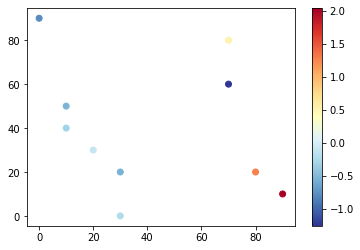

In [142]:
img0 = plt.scatter(Primary["X"], Primary["Y"], c=Primary["Secondary"].values,cmap = "RdYlBu_r")
plt.colorbar(img0)

In [143]:
X = Primary["X"].astype(float).values
Y = Primary["Y"].astype(float).values
Z = Primary["Secondary"].astype(float).values
print("size X :", len(X))
print("size Y :", len(Y))
print("size Z :", len(Z))

size X : 10
size Y : 10
size Z : 10


#### estimation de la distance maximale à retenir

In [144]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 120.41594578792295


In [145]:
L=(max(X)-min(X))*3/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 10.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 90.0  	 Distance maximale retenue : 90.0
nlag : 9


In [146]:
direction = [0,90]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 10
direction done : 0
RUN TIME : 0.00035440002102404833
Iteration 0 / 10
direction done : 90
RUN TIME : 0.00011190000805072486


Text(0.5, 0.98, 'Variogramme de la variable croisée ZY')

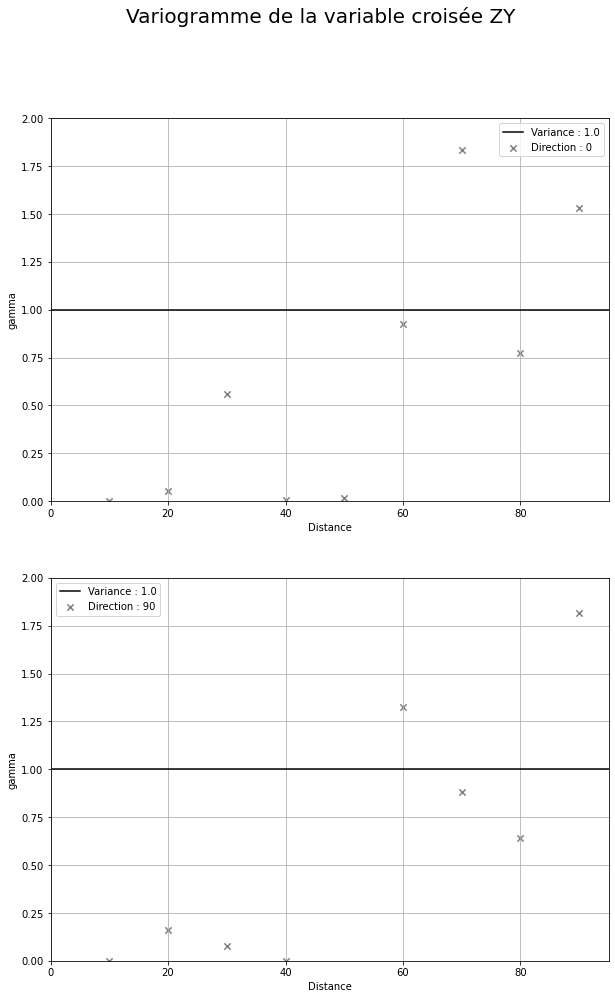

In [147]:
var_zy = float("{:.2f}".format(Primary["Secondary"].var()))
ones = np.ones(shape=(int(L+20))) * var_zy
H    = np.arange(0,int(L+20))
fig,ax=plt.subplots(2,1,figsize = (10,15.5))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii].plot(H,ones,"black", label = "Variance : " + str(var_z))
    ax[ii].set_xlabel('Distance')
    ax[ii].set_ylabel('gamma')
    ax[ii].grid()
    ax[ii].legend()
    ax[ii].set_ylim([0,2])
    ax[ii].set_xlim([0,max(dist_dir)+5])
    ii += 1
    if jj == 2 :
        ii += 1
        jj = 0
fig.suptitle("Variogramme de la variable croisée ZY", size = 20)

In [148]:
## MAJOR DIRECTION / MINOR DIRECTION :
Direction = {"Major" : 0,
            "Minor" : 90,
            }

In [149]:
for direction in dist :
    if direction == 0 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 90 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_3 = pd.DataFrame()
varc_3["Lag Distance"] = dist_array
varc_3["Number of Pairs"] = count_array
varc_3["Variogram Value"] = gam_array
varc_3["Variogram Index"] = index_array 
varc_3 = varc_3.loc[varc_3["Variogram Value"] != 0]
varc_3 = varc_3.dropna(axis = 0)

In [150]:
varc_3 = varc_3.loc[varc_3["Number of Pairs"] != 1.0]

# Correlogramme Model

In [151]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    return c

In [152]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

In [153]:
## Define some matrices for storing variogram values
LENGTH = 150
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [1,1,corr] ## !!

### Plottting labels 
colors = ["Red", "Green","Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


## Primary

In [154]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,dict_C_Z,nstruct = 1,Azimuth = 0):
    C = []
    #nstruct = 1
    vtype = dict_C_Z["vtype"]
    a_max = dict_C_Z["a_max"]
    a_min = dict_C_Z["a_min"] 
    cc = dict_C_Z["cc"]
    #Azimuth = 45
    c = 0
    #print(vtype,a_max,a_min,cc)
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] 
    return c

In [155]:
def optimize_RMSE_Z_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_z_0 = [x[0]]         # range
        a_min_z_0 = [x[1]]
        cc_z_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_z_0 = x[0::3]        # range
        a_min_z_0 = x[1::3]
        cc_z_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_primary_0 = {"a_max" : a_max_z_0
                ,"a_min" : a_min_z_0
                ,"cc" : cc_z_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_primary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k, dict_primary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [214]:
varc_1 = varc_1.loc[varc_1["Lag Distance"] != 30] 
varc_1 = varc_1.loc[varc_1["Variogram Value"] < 1] 

In [215]:
varc_1

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,3.0,0.268026,1.0
4,50.0,2.0,0.493416,1.0
7,80.0,8.0,0.848483,1.0
10,20.0,2.0,0.069476,2.0
15,70.0,4.0,0.732281,2.0
16,80.0,7.0,0.639527,2.0


In [202]:
Sill_vals[i]

1

In [216]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_z_0 = np.array([20])
a_min_z_0 = np.array([30])
cc_z_0    = np.array([0.5])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_z_0[i]
    b = a_min_z_0[i]
    c = cc_z_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,1.5]]
if nstruct > 1 :
    Bounds *=  len(a_max_z_0)


# Minimize
Z_model = minimize(optimize_RMSE_Z_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(Z_model)

a_max_z = [float("{:.0f}".format(x)) for x in Z_model.x[0::3]]
a_min_z = [float("{:.0f}".format(x)) for x in Z_model.x[1::3]]
cc_z = [float("{:.2f}".format(x)) for x in Z_model.x[2::3]]

dict_primary = {"a_max" : a_max_z
                ,"a_min" : a_min_z
                ,"cc" : cc_z
                ,"vtype" : MODEL_value,
                "nstruct" : nstruct
}

{'a_max': [20.0], 'a_min': [30.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.5213347461731512, 0.5583073090938893] 

{'a_max': [19.999878890910953], 'a_min': [30.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.5213347461731512, 0.5583073090938893] 

{'a_max': [20.000121109089047], 'a_min': [30.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.5213347461602804, 0.5583073090938893] 

{'a_max': [20.0], 'a_min': [29.999818336366427], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.5213347461731512, 0.5583081692009193] 

{'a_max': [20.0], 'a_min': [30.000181663633573], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.5213347461731512, 0.5583064489893068] 

{'a_max': [20.0], 'a_min': [30.0], 'cc': [0.49999394454554763], 'vtype': [1]}
RMSE : [0.5213347461731512, 0.5583077678170377] 

{'a_max': [20.0], 'a_min': [30.0], 'cc': [0.5000060554544524], 'vtype': [1]}
RMSE : [0.5213347461731512, 0.5583068503708444] 

{'a_max': [20.000000000026766], 'a_min': [30.000002384620508], 'cc': [0.5000000038153928], 'vtype': [1]}
RMSE : [0.52133474617315

RMSE : [0.21118014052831574, 0.19882581862824641] 

{'a_max': [74.58742811769204], 'a_min': [149.99818336366428], 'cc': [1.4596995468526313], 'vtype': [1]}
RMSE : [0.21118014052831574, 0.19882278233762854] 

{'a_max': [74.58742811769204], 'a_min': [150.0], 'cc': [1.459690707708511], 'vtype': [1]}
RMSE : [0.21117942635584516, 0.1988245750077266] 

{'a_max': [74.58742811769204], 'a_min': [150.0], 'cc': [1.4597083859967515], 'vtype': [1]}
RMSE : [0.2111808547464694, 0.1988331348733842] 

{'a_max': [71.57103849849901], 'a_min': [150.0], 'cc': [1.4395493202789469], 'vtype': [1]}
RMSE : [0.22084711550601577, 0.18912135274282244] 

{'a_max': [71.57060510333527], 'a_min': [150.0], 'cc': [1.4395493202789469], 'vtype': [1]}
RMSE : [0.22084883633037877, 0.18912135274282244] 

{'a_max': [71.57147189366275], 'a_min': [150.0], 'cc': [1.4395493202789469], 'vtype': [1]}
RMSE : [0.220845394712942, 0.18912135274282244] 

{'a_max': [71.57103849849901], 'a_min': [149.99909168183214], 'cc': [1.439549320278

{'a_max': [149.99818336366428], 'a_min': [128.8492572596299], 'cc': [1.2167292184715979], 'vtype': [1]}
RMSE : [0.19002179903611577, 0.08225108031883432] 

{'a_max': [150.0], 'a_min': [128.84847701882134], 'cc': [1.2167292184715979], 'vtype': [1]}
RMSE : [0.19002718471788782, 0.0822523449626531] 

{'a_max': [150.0], 'a_min': [128.85003750043845], 'cc': [1.2167292184715979], 'vtype': [1]}
RMSE : [0.19002718471788782, 0.0822498158146369] 

{'a_max': [150.0], 'a_min': [128.8492572596299], 'cc': [1.2167218506232345], 'vtype': [1]}
RMSE : [0.19002318057598294, 0.0822512637529977] 

{'a_max': [150.0], 'a_min': [128.8492572596299], 'cc': [1.2167365863199613], 'vtype': [1]}
RMSE : [0.19003118886939124, 0.08225089703765882] 

{'a_max': [123.36853875797887], 'a_min': [136.34378974720494], 'cc': [1.147034594205419], 'vtype': [1]}
RMSE : [0.08339128747939019, 0.07756716625497717] 

{'a_max': [123.36779170541156], 'a_min': [136.34378974720494], 'cc': [1.147034594205419], 'vtype': [1]}
RMSE : [0.083

RMSE : [0.05287588195879318, 0.08716001139776686] 

{'a_max': [123.99799498298539], 'a_min': [150.0], 'cc': [1.0529728981745257], 'vtype': [1]}
RMSE : [0.05287459372622576, 0.08716123835096191] 

{'a_max': [123.99799498298539], 'a_min': [150.0], 'cc': [1.0529856507105972], 'vtype': [1]}
RMSE : [0.05287717036211633, 0.0871586409602036] 

{'a_max': [123.9979949731218], 'a_min': [150.0], 'cc': [1.0529792744855753], 'vtype': [1]}
RMSE : [0.05287588196683101, 0.08715993959110993] 

{'a_max': [123.99724410891106], 'a_min': [150.0], 'cc': [1.0529792744855753], 'vtype': [1]}
RMSE : [0.05287583233187747, 0.08715993959110993] 

{'a_max': [123.99874583733255], 'a_min': [150.0], 'cc': [1.0529792744855753], 'vtype': [1]}
RMSE : [0.052875931765121155, 0.08715993959110993] 

{'a_max': [123.9979949731218], 'a_min': [149.99909168183214], 'cc': [1.0529792744855753], 'vtype': [1]}
RMSE : [0.05287588196683101, 0.08715997543817079] 

{'a_max': [123.9979949731218], 'a_min': [149.99818336366428], 'cc': [1.05

###  Visualisation du model Z

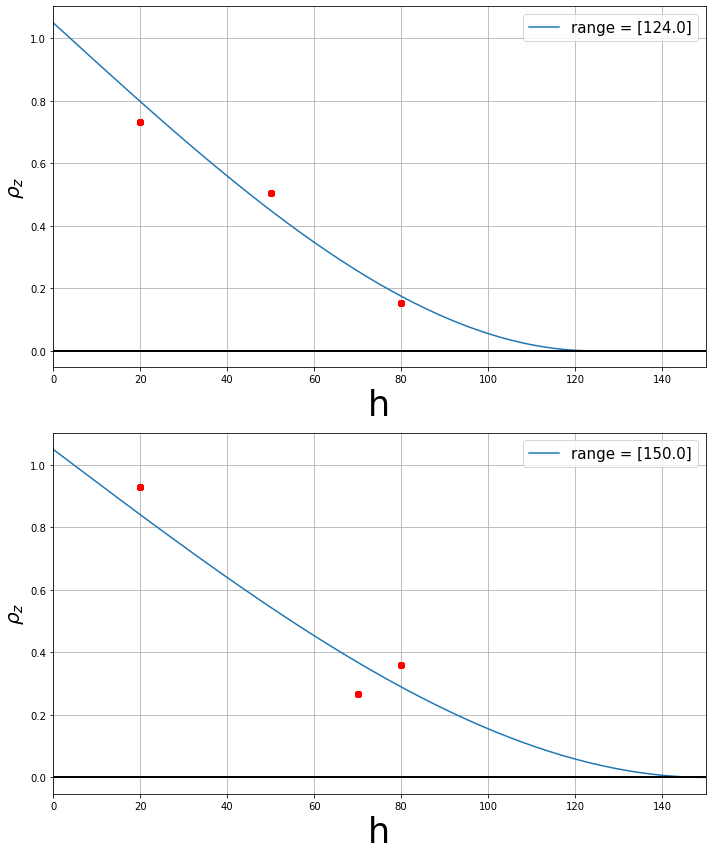

In [218]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = dict_primary["nstruct"]
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_primary["a_max"],
             1 : dict_primary["a_min"]}

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_primary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_primary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cz_True = np.zeros(shape=(LENGTH + 1))
for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type, dict_primary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        #axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, LENGTH))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Secondary

In [158]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,dict_C_Y,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_Y["vtype"]
    a_max = dict_C_Y["a_max"]
    a_min = dict_C_Y["a_min"] 
    cc = dict_C_Y["cc"]
    #Azimuth = 45
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

In [159]:
def optimize_RMSE_Y_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_y_0 = [x[0]]         # range
        a_min_y_0 = [x[1]]
        cc_y_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_y_0 = x[0::3]        # range
        a_min_y_0 = x[1::3]
        cc_y_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_secondary_0 = {"a_max" : a_max_y_0
                ,"a_min" : a_min_y_0
                ,"cc" : cc_y_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_secondary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k, dict_secondary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [160]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_y_0 = np.array([50])
a_min_y_0 = np.array([72])
cc_y_0    = np.array([0.5])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_2, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_y_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_y_0[i]
    b = a_min_y_0[i]
    c = cc_y_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,1]]
if nstruct > 1 :
    Bounds *=  len(a_max_y_0)


Y_model = minimize(optimize_RMSE_Y_model,x0,args = args,
                            method='TNC', jac = '3-point',# Minimize
                            bounds = Bounds,tol = 1e-9)


print(Y_model)

a_max_y = [float("{:.0f}".format(x)) for x in Y_model.x[0::3]]
a_min_y = [float("{:.0f}".format(x)) for x in Y_model.x[1::3]]
cc_y = [float("{:.2f}".format(x)) for x in Y_model.x[2::3]]

dict_secondary = {"a_max" : a_max_y
                ,"a_min" : a_min_y
                ,"cc" : cc_y
                ,"vtype" : MODEL_value
                  ,"nstruct" : nstruct
}

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.1577411921233429] 

{'a_max': [49.99969722727738], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17642065819020797, 0.1577411921233429] 

{'a_max': [50.00030277272262], 'a_min': [72.0], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641817093329182, 0.1577411921233429] 

{'a_max': [50.0], 'a_min': [71.99956400727943], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.1577424540037708] 

{'a_max': [50.0], 'a_min': [72.00043599272057], 'cc': [0.5], 'vtype': [1]}
RMSE : [0.17641941455796656, 0.15773993025501504] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.49999394454554763], 'vtype': [1]}
RMSE : [0.17642151673353088, 0.1577440440185249] 

{'a_max': [50.0], 'a_min': [72.0], 'cc': [0.5000060554544524], 'vtype': [1]}
RMSE : [0.17641731240216987, 0.15773834025135408] 

{'a_max': [50.00000160830423], 'a_min': [72.00000113326423], 'cc': [0.5000000142372254], 'vtype': [1]}
RMSE : [0.17641940300

{'a_max': [74.980697903886], 'a_min': [105.3203749679177], 'cc': [0.6302184339494226], 'vtype': [1]}
RMSE : [0.05830716805792318, 0.03405471188345076] 

{'a_max': [74.98160599378683], 'a_min': [105.3203749679177], 'cc': [0.6302184339494226], 'vtype': [1]}
RMSE : [0.05830687511436437, 0.03405471188345076] 

{'a_max': [74.98115194883641], 'a_min': [105.31973720518417], 'cc': [0.6302184339494226], 'vtype': [1]}
RMSE : [0.05830702156036747, 0.03405477782206493] 

{'a_max': [74.98115194883641], 'a_min': [105.32101273065123], 'cc': [0.6302184339494226], 'vtype': [1]}
RMSE : [0.05830702156036747, 0.03405464600136854] 

{'a_max': [74.98115194883641], 'a_min': [105.3203749679177], 'cc': [0.6302123784949701], 'vtype': [1]}
RMSE : [0.05830782277734088, 0.034054300362941506] 

{'a_max': [74.98115194883641], 'a_min': [105.3203749679177], 'cc': [0.630224489403875], 'vtype': [1]}
RMSE : [0.05830622054321814, 0.03405512389056013] 

{'a_max': [74.98115198159036], 'a_min': [105.32037500526204], 'cc': [0

RMSE : [0.05800293058635002, 0.03410381404620714] 

{'a_max': [76.22561293101012], 'a_min': [105.87666566629318], 'cc': [0.6311467442315262], 'vtype': [1]}
RMSE : [0.05800293296152417, 0.03410381404620714] 

{'a_max': [76.22515135307798], 'a_min': [105.87602453496666], 'cc': [0.6311467442315262], 'vtype': [1]}
RMSE : [0.05800293174877788, 0.034103812472406375] 

{'a_max': [76.22515135307798], 'a_min': [105.8773067976197], 'cc': [0.6311467442315262], 'vtype': [1]}
RMSE : [0.05800293174877788, 0.03410381567562039] 

{'a_max': [76.22515135307798], 'a_min': [105.87666566629318], 'cc': [0.6311406887770737], 'vtype': [1]}
RMSE : [0.05800352119336824, 0.03410322110346661] 

{'a_max': [76.22515135307798], 'a_min': [105.87666566629318], 'cc': [0.6311527996859786], 'vtype': [1]}
RMSE : [0.05800234251369074, 0.03410440747155349] 

{'a_max': [76.22515135243137], 'a_min': [105.87666566015058], 'cc': [0.6311467442277388], 'vtype': [1]}
RMSE : [0.05800293174914482, 0.03410381404582079] 

{'a_max': [7

In [161]:
dict_secondary

{'a_max': [76.0],
 'a_min': [106.0],
 'cc': [0.63],
 'vtype': array([1]),
 'nstruct': 1}

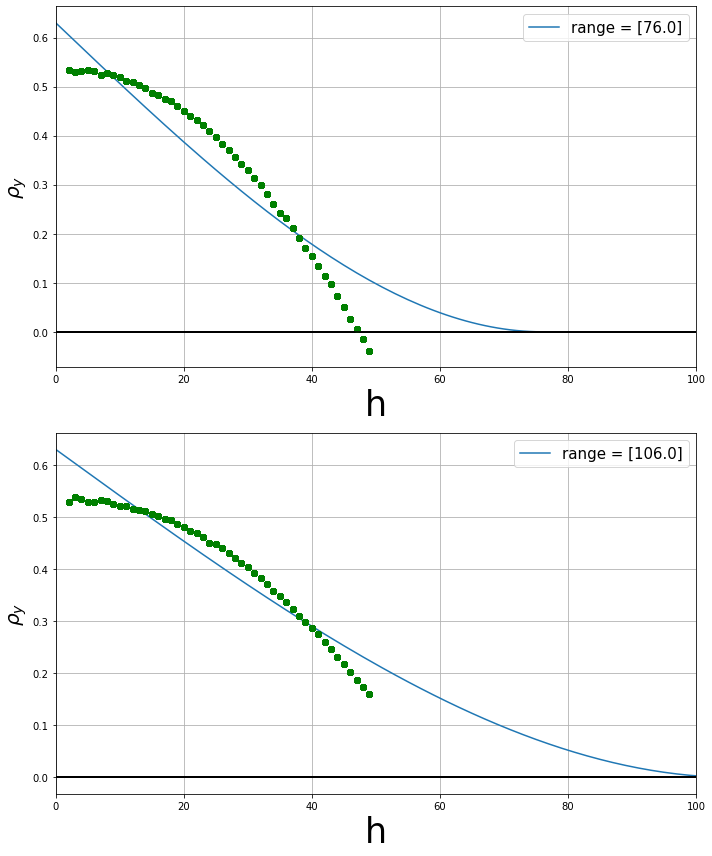

In [162]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = 1

MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_secondary["a_max"],
             1 : dict_secondary["a_min"]}

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_secondary["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_secondary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_secondary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h),varg_type, dict_secondary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [1]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )
        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        #axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

## Cross

In [163]:
def C_ZY(h1, h2, k,dict_C_ZY,nstruct = 1,Azimuth = 0):
    C = []
    vtype = dict_C_ZY["vtype"]
    a_max = dict_C_ZY["a_max"]
    a_min = dict_C_ZY["a_min"] 
    cc = dict_C_ZY["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

In [164]:
varc_3

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,3.0,0.051447,1.0
2,30.0,3.0,0.559429,1.0
4,50.0,2.0,0.015523,1.0
5,60.0,4.0,0.925716,1.0
6,70.0,4.0,1.831775,1.0
7,80.0,8.0,0.773284,1.0
8,90.0,2.0,1.530443,1.0
10,20.0,2.0,0.161562,2.0
11,30.0,2.0,0.075967,2.0
14,60.0,7.0,1.326240,2.0


In [165]:
def optimize_RMSE_ZY_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_zy_0 = [x[0]]         # range
        a_min_zy_0 = [x[1]]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = [args[3]]     # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_zy_0 = x[0::3]        # range
        a_min_zy_0 = x[1::3]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = args[3::]     # type de modèle
        nstruct = len(MODEL_value)  # nombre de couche
    
    dict_cross_0 = {"a_max" : a_max_zy_0
                ,"a_min" : a_min_zy_0
                ,"cc" : cc_zy_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_cross_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k, dict_cross_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [166]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

corr = np.corrcoef(Primary["Primary"].dropna(axis = 0), Primary["Secondary"].dropna(axis = 0))[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_zy_0  = np.array([100])
a_min_zy_0  = np.array([100])
cc_zy_0     = [corr]
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_3, corr # variogram , Variance
nstruct = len(a_max_zy_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_zy_0[i]
    b = a_min_zy_0[i]
    c = cc_zy_0[i] # cc n'est pas à minimiser ici 
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[c,d])
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[10,150],[10,150]]
if nstruct > 1 :
    Bounds *=  len(a_max_zy_0)


# Minimize
ZY_model = minimize(optimize_RMSE_ZY_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(ZY_model)

a_max_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[0::3]]
a_min_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[1::3]]
cc_zy = [corr]

dict_cross = {"a_max" : a_max_zy
                ,"a_min" : a_min_zy
                ,"cc" : cc_zy
                ,"vtype" : MODEL_value
              ,"nstruct"  : nstruct
}

Coeff de correlation : 0.45
{'a_max': array([100.]), 'a_min': array([100.]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7478783781215056, 0.7205769232698799] 

{'a_max': array([99.99939445]), 'a_min': array([100.]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7478776044832772, 0.7205769232698799] 

{'a_max': array([100.00060555]), 'a_min': array([100.]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7478791517663448, 0.7205769232698799] 

{'a_max': array([100.]), 'a_min': array([99.99939445]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7478783781215056, 0.7205761533281715] 

{'a_max': array([100.]), 'a_min': array([100.00060555]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7478783781215056, 0.7205776932203345] 

{'a_max': array([99.99999955]), 'a_min': array([99.99999955]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7478783775484752, 0.7205769227023109] 

{'a_max': array([99.99939401

RMSE : [0.7238320340954819, 0.6955441699144966] 

{'a_max': array([65.47313748]), 'a_min': array([63.58698797]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7238320340954819, 0.695544166362542] 

{'a_max': array([65.43305079]), 'a_min': array([63.63405775]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.723832003303763, 0.695544020444211] 

{'a_max': array([65.43265456]), 'a_min': array([63.63405775]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7238320031615052, 0.695544020444211] 

{'a_max': array([65.43344701]), 'a_min': array([63.63405775]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7238320034491967, 0.695544020444211] 

{'a_max': array([65.43305079]), 'a_min': array([63.63367242]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.723832003303763, 0.695544021071007] 

{'a_max': array([65.43305079]), 'a_min': array([63.63444309]), 'cc': [0.45], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7238320033037

In [167]:
dict_cross

{'a_max': [65.0],
 'a_min': [64.0],
 'cc': [0.45],
 'vtype': array([1]),
 'nstruct': 1}

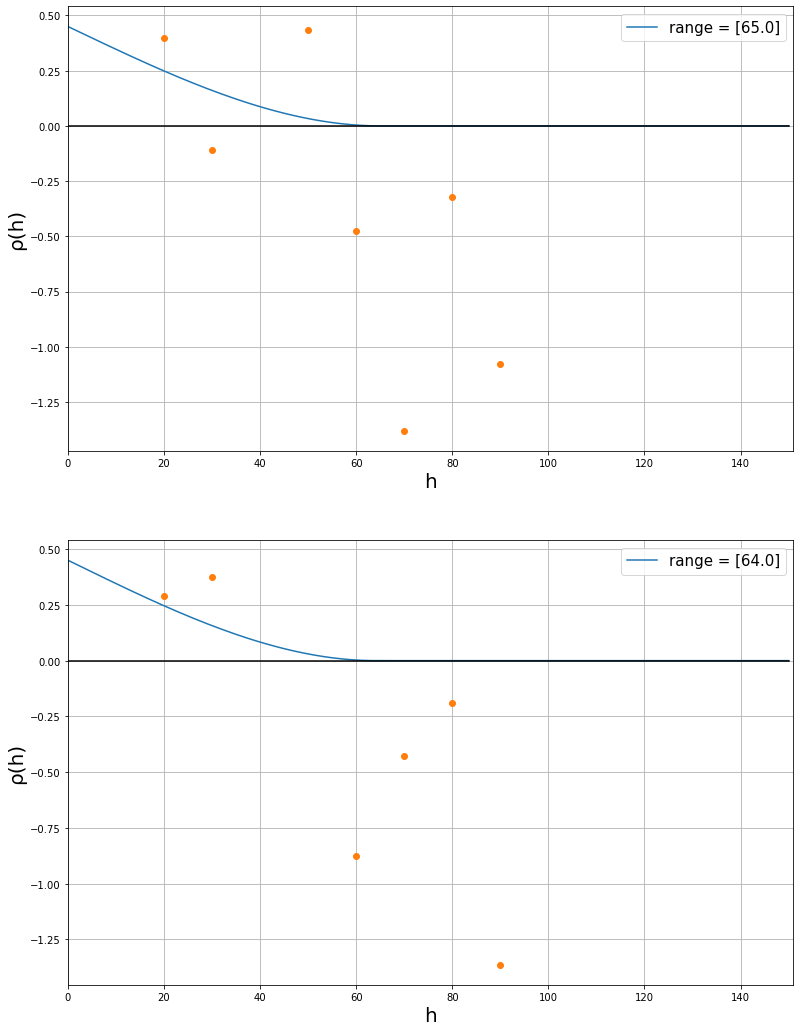

In [168]:
## Constantes de démarrage
varg_type = 2  # See Correlogram Functions
nstruct = dict_cross["nstruct"]
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

label_dict = {0: dict_cross["a_max"],
             1 : dict_cross["a_min"]}

fig, axes = plt.subplots(2, 1, figsize=(13, 18))
czy = np.zeros(shape=(LENGTH + 1))

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_cross["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_cross["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_cross["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

for s in range(2) :

    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in [2]: 
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)

        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (s + 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (s + 1)
                ],
                "o"
                )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[s].set_ylabel("\u03C1(h)", size=20)
    axes[s].set_xlabel("h", size=20)
    #axes[s].set_title(TITLE,size=20)
    axes[s].legend(loc="best", prop={"size": 15})
    varg_type = varg_type + 1

    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

# Correlogram MM2 

### Scalling Correlogram 

In [169]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, dict_C_r,nstruct = 1,Azimuth = 0 ):
    C = []
    vtype = dict_C_r["vtype"]
    a_max = dict_C_r["a_max"]
    a_min = dict_C_r["a_min"] 
    cc = dict_C_r["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### C_Z_MM2

In [170]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,dict_secondary, dict_C_r ):
    
    return (C_Y_alternate(h1, h2, k,dict_secondary, nstruct = 1) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k,dict_C_r,nstruct = 1 )
    )

In [171]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On minimize ici la différence entre le correlogram généré C_Z_MII ( qui se base sur le correlogram Y) et
    le modèle de correlogram ce C_Z. Les modifications s'effectuent sur le correlogram C_r 
    """
    
    dict_secondary = args[0] # dictionnaire des valeurs du correlogram secondaire
    dict_primary   = args[1] # dictionnaire des valeurs du correlogram primaire
    corr  = args[2]
    RMSE = [] # Liste des RMSE
    
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    ## x0
    if len(x0) == 3 :
        a_max_r_0 = [x[0]]         # range
        a_min_r_0 = [x[1]]
        cc_r_0 = [x[2]]            # effet pépite
        MODEL_value = [args[3]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible.
        
        a_max_r_0 = x[0::3]        # range
        a_min_r_0 = x[1::3]
        cc_r_0 = x[2::3]           # effet pépite
        MODEL_value = args[3::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_scalling_0 = {"a_max" : a_max_r_0
                ,"a_min" : a_min_r_0
                ,"cc" : cc_r_0
                ,"vtype" : MODEL_value
                 }
    print(dict_scalling_0)
    for i,Dir in enumerate(Direction) :
        
        # Inititialisation des matrices
        cy = np.zeros(shape=(101))
        cr = np.zeros(shape=(101))
        cz_mm2 = np.zeros(shape=(101))
        cz = np.zeros(shape=(101))
        k = i + 2                # numéro de la direction 
        
        for h in range(0, 101):
            cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_secondary, nstruct = 1)

            cz[h] = C_Z_alternate(np.matrix(h), np.matrix(h),k,
                                  dict_primary, nstruct = 1)

            cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                        dict_scalling_0,nstruct = 1 )

            cz_mm2[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,dict_secondary, dict_scalling_0)

            RMSE.append(np.sqrt(mean_squared_error(cz,cz_mm2))) 
    return sum(RMSE)

In [172]:
corr

0.45

In [173]:
print('-' * 30)
print("dict_primary :", dict_primary)
print("dict_secondary :", dict_secondary)
print("dict_cross :", dict_cross)

------------------------------
dict_primary : {'a_max': [73.0], 'a_min': [98.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary : {'a_max': [76.0], 'a_min': [106.0], 'cc': [0.63], 'vtype': array([1]), 'nstruct': 1}
dict_cross : {'a_max': [65.0], 'a_min': [64.0], 'cc': [0.45], 'vtype': array([1]), 'nstruct': 1}


In [174]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_r_0 = np.array([80])
a_min_r_0 = np.array([80])
cc_r_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])
nstruct = len(a_max_r_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[dict_secondary,dict_primary,corr])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_r_0[i]
    b = a_min_r_0[i]
    c = cc_r_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0.01,150],[0.01,150],[0.01,5]]
if nstruct > 1 :
    Bounds *=  nstruct


# Minimize
scalling_model = minimize(optimize_RMSE_scalling_correlogram,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(scalling_model)

a_max_r = [float("{:.0f}".format(x)) for x in scalling_model.x[0::3]]
a_min_r = [float("{:.0f}".format(x)) for x in scalling_model.x[1::3]]
cc_r = [float("{:.2f}".format(x)) for x in scalling_model.x[2::3]]

dict_scalling = {"a_max" : a_max_r
                ,"a_min" : a_min_r
                ,"cc" : cc_r
                ,"vtype" : MODEL_value
}

{'a_max': [80.0], 'a_min': [80.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [79.99951556364381], 'a_min': [80.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [80.00048443635619], 'a_min': [80.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [80.0], 'a_min': [79.99951556364381], 'cc': [2.0], 'vtype': [1]}
{'a_max': [80.0], 'a_min': [80.00048443635619], 'cc': [2.0], 'vtype': [1]}
{'a_max': [80.0], 'a_min': [80.0], 'cc': [1.9999878890910952], 'vtype': [1]}
{'a_max': [80.0], 'a_min': [80.0], 'cc': [2.0000121109089046], 'vtype': [1]}
{'a_max': [79.99999961808703], 'a_min': [79.99999971544561], 'cc': [1.9999999188760667], 'vtype': [1]}
{'a_max': [79.99951518173316], 'a_min': [79.99999971544561], 'cc': [1.9999999188760667], 'vtype': [1]}
{'a_max': [80.0004840544409], 'a_min': [79.99999971544561], 'cc': [1.9999999188760667], 'vtype': [1]}
{'a_max': [79.99999961808703], 'a_min': [79.99951527909114], 'cc': [1.9999999188760667], 'vtype': [1]}
{'a_max': [79.99999961808703], 'a_min': [80.00048415180008], 'cc': [1.999

{'a_max': [73.42669157604526], 'a_min': [78.9224129987361], 'cc': [1.0637825520076802], 'vtype': [1]}
{'a_max': [74.61134049939494], 'a_min': [77.89505168494189], 'cc': [1.0853912118771143], 'vtype': [1]}
{'a_max': [74.61088869382091], 'a_min': [77.89505168494189], 'cc': [1.0853912118771143], 'vtype': [1]}
{'a_max': [74.61179230496897], 'a_min': [77.89505168494189], 'cc': [1.0853912118771143], 'vtype': [1]}
{'a_max': [74.61134049939494], 'a_min': [77.89457999500435], 'cc': [1.0853912118771143], 'vtype': [1]}
{'a_max': [74.61134049939494], 'a_min': [77.89552337487943], 'cc': [1.0853912118771143], 'vtype': [1]}
{'a_max': [74.61134049939494], 'a_min': [77.89505168494189], 'cc': [1.0853846393400677], 'vtype': [1]}
{'a_max': [74.61134049939494], 'a_min': [77.89505168494189], 'cc': [1.085397784414161], 'vtype': [1]}
{'a_max': [74.61133961895756], 'a_min': [77.89505208611075], 'cc': [1.0853912127159548], 'vtype': [1]}
{'a_max': [74.61088781338886], 'a_min': [77.89505208611075], 'cc': [1.08539

{'a_max': [70.42012468485031], 'a_min': [92.15894268782782], 'cc': [1.1197139843212105], 'vtype': [1]}
{'a_max': [70.41969826157494], 'a_min': [92.15838462354799], 'cc': [1.1197139843212105], 'vtype': [1]}
{'a_max': [70.41969826157494], 'a_min': [92.15950075210765], 'cc': [1.1197139843212105], 'vtype': [1]}
{'a_max': [70.41969826157494], 'a_min': [92.15894268782782], 'cc': [1.1197072039441787], 'vtype': [1]}
{'a_max': [70.41969826157494], 'a_min': [92.15894268782782], 'cc': [1.1197207646982423], 'vtype': [1]}
{'a_max': [71.34448982571168], 'a_min': [101.31869340402439], 'cc': [1.1089415271452907], 'vtype': [1]}
{'a_max': [71.34405780240311], 'a_min': [101.31869340402439], 'cc': [1.1089415271452907], 'vtype': [1]}
{'a_max': [71.34492184902024], 'a_min': [101.31869340402439], 'cc': [1.1089415271452907], 'vtype': [1]}
{'a_max': [71.34448982571168], 'a_min': [101.3180798732913], 'cc': [1.1089415271452907], 'vtype': [1]}
{'a_max': [71.34448982571168], 'a_min': [101.31930693475748], 'cc': [1

{'a_max': [72.74552223820488], 'a_min': [95.24402001747521], 'cc': [1.0782835532434116], 'vtype': [1]}
{'a_max': [72.74552223820488], 'a_min': [95.24402001747521], 'cc': [1.0782966123163773], 'vtype': [1]}
{'a_max': [71.93692084255947], 'a_min': [96.49165708501968], 'cc': [1.0872272382255876], 'vtype': [1]}
{'a_max': [71.93648523181187], 'a_min': [96.49165708501968], 'cc': [1.0872272382255876], 'vtype': [1]}
{'a_max': [71.93735645330707], 'a_min': [96.49165708501968], 'cc': [1.0872272382255876], 'vtype': [1]}
{'a_max': [71.93692084255947], 'a_min': [96.49107278418516], 'cc': [1.0872272382255876], 'vtype': [1]}
{'a_max': [71.93692084255947], 'a_min': [96.4922413858542], 'cc': [1.0872272382255876], 'vtype': [1]}
{'a_max': [71.93692084255947], 'a_min': [96.49165708501968], 'cc': [1.0872206545705672], 'vtype': [1]}
{'a_max': [71.93692084255947], 'a_min': [96.49165708501968], 'cc': [1.0872338218806081], 'vtype': [1]}
{'a_max': [71.53262014473677], 'a_min': [97.11547561879193], 'cc': [1.0916

{'a_max': [72.72589088123745], 'a_min': [96.10377973108098], 'cc': [1.0947022336901526], 'vtype': [1]}
{'a_max': [72.72589088123745], 'a_min': [96.1049436422507], 'cc': [1.0947022336901526], 'vtype': [1]}
{'a_max': [72.72589088123745], 'a_min': [96.10436168666584], 'cc': [1.0946956047706375], 'vtype': [1]}
{'a_max': [72.72589088123745], 'a_min': [96.10436168666584], 'cc': [1.0947088626096677], 'vtype': [1]}
{'a_max': [72.57518225486831], 'a_min': [96.09951119914571], 'cc': [1.0946385444146944], 'vtype': [1]}
{'a_max': [72.57474277915779], 'a_min': [96.09951119914571], 'cc': [1.0946385444146944], 'vtype': [1]}
{'a_max': [72.57562173057883], 'a_min': [96.09951119914571], 'cc': [1.0946385444146944], 'vtype': [1]}
{'a_max': [72.57518225486831], 'a_min': [96.09892927293275], 'cc': [1.0946385444146944], 'vtype': [1]}
{'a_max': [72.57518225486831], 'a_min': [96.10009312535867], 'cc': [1.0946385444146944], 'vtype': [1]}
{'a_max': [72.57518225486831], 'a_min': [96.09951119914571], 'cc': [1.0946

{'a_max': [72.53076075091836], 'a_min': [96.83429511413829], 'cc': [1.0946249780968604], 'vtype': [1]}
{'a_max': [72.53032154420023], 'a_min': [96.83429511413829], 'cc': [1.0946249780968604], 'vtype': [1]}
{'a_max': [72.53119995763649], 'a_min': [96.83429511413829], 'cc': [1.0946249780968604], 'vtype': [1]}
{'a_max': [72.53076075091836], 'a_min': [96.8337087384748], 'cc': [1.0946249780968604], 'vtype': [1]}
{'a_max': [72.53076075091836], 'a_min': [96.83488148980177], 'cc': [1.0946249780968604], 'vtype': [1]}
{'a_max': [72.53076075091836], 'a_min': [96.83429511413829], 'cc': [1.0946183496451631], 'vtype': [1]}
{'a_max': [72.53076075091836], 'a_min': [96.83429511413829], 'cc': [1.0946316065485577], 'vtype': [1]}
{'a_max': [72.60733542835457], 'a_min': [96.95014160041045], 'cc': [1.0940367309310384], 'vtype': [1]}
{'a_max': [72.60689575794198], 'a_min': [96.95014160041045], 'cc': [1.0940367309310384], 'vtype': [1]}
{'a_max': [72.60777509876716], 'a_min': [96.95014160041045], 'cc': [1.0940

{'a_max': [72.57139966111669], 'a_min': [96.90778815214453], 'cc': [1.0939636303230789], 'vtype': [1]}
{'a_max': [72.57139966111669], 'a_min': [96.90720133500074], 'cc': [1.093957005876143], 'vtype': [1]}
{'a_max': [72.57139966111669], 'a_min': [96.90720133500074], 'cc': [1.0939702547700147], 'vtype': [1]}
{'a_max': [72.57538909448601], 'a_min': [96.9063800162348], 'cc': [1.093969088981762], 'vtype': [1]}
{'a_max': [72.57494961752299], 'a_min': [96.9063800162348], 'cc': [1.093969088981762], 'vtype': [1]}
{'a_max': [72.57582857144904], 'a_min': [96.9063800162348], 'cc': [1.093969088981762], 'vtype': [1]}
{'a_max': [72.57538909448601], 'a_min': [96.90579320406447], 'cc': [1.093969088981762], 'vtype': [1]}
{'a_max': [72.57538909448601], 'a_min': [96.90696682840515], 'cc': [1.093969088981762], 'vtype': [1]}
{'a_max': [72.57538909448601], 'a_min': [96.9063800162348], 'cc': [1.0939624645017714], 'vtype': [1]}
{'a_max': [72.57538909448601], 'a_min': [96.9063800162348], 'cc': [1.09397571346175

{'a_max': [72.57000712293951], 'a_min': [96.90087421776107], 'cc': [1.0939956614155364], 'vtype': [1]}
{'a_max': [72.57088601700711], 'a_min': [96.90087421776107], 'cc': [1.0939956614155364], 'vtype': [1]}
{'a_max': [72.57044656997331], 'a_min': [96.90028743893085], 'cc': [1.0939956614155364], 'vtype': [1]}
{'a_max': [72.57044656997331], 'a_min': [96.9014609965913], 'cc': [1.0939956614155364], 'vtype': [1]}
{'a_max': [72.57044656997331], 'a_min': [96.90087421776107], 'cc': [1.0939890367746377], 'vtype': [1]}
{'a_max': [72.57044656997331], 'a_min': [96.90087421776107], 'cc': [1.0940022860564351], 'vtype': [1]}
{'a_max': [72.57044656997242], 'a_min': [96.90087421775897], 'cc': [1.0939956614155502], 'vtype': [1]}
{'a_max': [72.57000712293862], 'a_min': [96.90087421775897], 'cc': [1.0939956614155502], 'vtype': [1]}
{'a_max': [72.57088601700622], 'a_min': [96.90087421775897], 'cc': [1.0939956614155502], 'vtype': [1]}
{'a_max': [72.57044656997242], 'a_min': [96.90028743892874], 'cc': [1.0939

{'a_max': [72.57040442979896], 'a_min': [96.90077522254973], 'cc': [1.0939896884451643], 'vtype': [1]}
{'a_max': [72.57040442979896], 'a_min': [96.90077522254973], 'cc': [1.0940029377348541], 'vtype': [1]}
{'a_max': [72.57040443001713], 'a_min': [96.90077522258032], 'cc': [1.0939963130518051], 'vtype': [1]}
{'a_max': [72.56996498323852], 'a_min': [96.90077522258032], 'cc': [1.0939963130518051], 'vtype': [1]}
{'a_max': [72.57084387679575], 'a_min': [96.90077522258032], 'cc': [1.0939963130518051], 'vtype': [1]}
{'a_max': [72.57040443001713], 'a_min': [96.90018844434955], 'cc': [1.0939963130518051], 'vtype': [1]}
{'a_max': [72.57040443001713], 'a_min': [96.90136200081109], 'cc': [1.0939963130518051], 'vtype': [1]}
{'a_max': [72.57040443001713], 'a_min': [96.90077522258032], 'cc': [1.0939896884069604], 'vtype': [1]}
{'a_max': [72.57040443001713], 'a_min': [96.90077522258032], 'cc': [1.0940029376966498], 'vtype': [1]}
{'a_max': [72.57040443012622], 'a_min': [96.90077522259563], 'cc': [1.093

In [175]:
print('-' * 30)
print("dict_scalling :", dict_scalling)
print("dict_secondary :", dict_secondary)
print("dict_cross :", dict_cross)


------------------------------
dict_scalling : {'a_max': [73.0], 'a_min': [97.0], 'cc': [1.09], 'vtype': array([1])}
dict_secondary : {'a_max': [76.0], 'a_min': [106.0], 'cc': [0.63], 'vtype': array([1]), 'nstruct': 1}
dict_cross : {'a_max': [65.0], 'a_min': [64.0], 'cc': [0.45], 'vtype': array([1]), 'nstruct': 1}


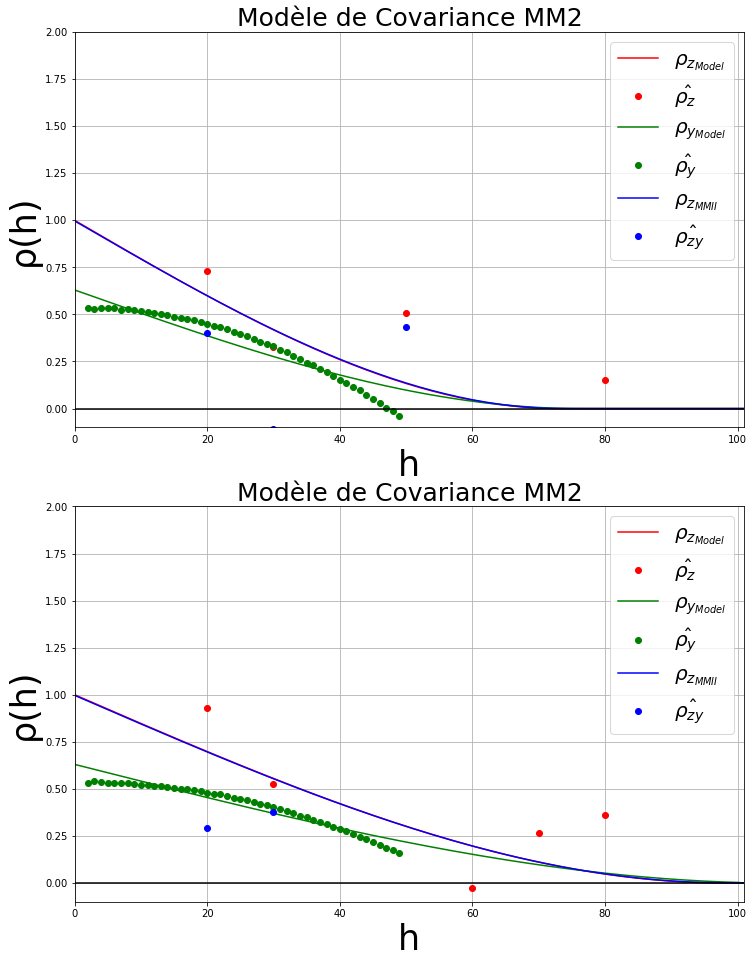

In [176]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{z_{MMII}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz_mm2 = np.zeros(shape=(LENGTH + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

        cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )

        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        "Modèle de Covariance MM2",
        size=25,y = 1
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

# LMC 

In [177]:
def optimize_RMSE_LMC_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On cherche à minimiser un seul modèle qui serait compatible avec les trois autres correlogrammes (pas les modèles) 
    """
    
    df_primary   = args[0] # DataFrame des valeurs primaire
    df_secondary = args[1] # DataFrame des valeurs secondaire
    df_cross     = args[2] # DataFrame des valeurs cross 
    sill_value_z = args[3]
    sill_value_y = args[4]
    corr         = args[5]
    nstruct      = args[-1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions 
    ## x0
    if nstruct == 1 : # modèle à une couche
        a_max_0 = [x[0]]         # range
        a_min_0 = [x[1]]
        cc_0 = x[2::]            # effet pépite
        MODEL_value = [args[6]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible avec les données.
    
        a_max_0 = x[0:-3*nstruct:nstruct]     # range
        a_min_0 = x[1:-3*nstruct:nstruct]
        cc_0 = x[nstruct*nstruct::]   # effet pépite
        MODEL_value = args[6:6+nstruct]      # type de modèle
        
        ## Condition des sills, il faut c1 + c2 + .. = sill_value du correlogram
        for i,sill in zip([0,1,2],[sill_value_z,sill_value_y,corr]) :
            for c1,c2 in [cc_0[i::3]] :
                if c1 + c2 > sill :
                    cc_0[i+3] = sill - cc_0[i]
                    print(cc_0[i],cc_0[i+3])

    dict_model_LMC_z = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[0::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_y = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[1::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_zy = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[2::3]
                ,"vtype" : MODEL_value
                 }
    
    print("Z : ",dict_model_LMC_z,'\n Y :',dict_model_LMC_y,'\n ZY :',dict_model_LMC_zy)
    for i,Dir in enumerate(Direction) :
        k = i + 2
        MODEL_y  = []
        MODEL_z  = []
        MODEL_zy = []
        
        ### Correlogramme Y
        lag_value_y = df_secondary["Lag Distance"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_y = sill_value_y - df_secondary["Variogram Value"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        
        for h in lag_value_y:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_y,nstruct)
            MODEL_y.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_y,MODEL_y)))
        
        ### Correlogramme Z
        lag_value_z = df_primary["Lag Distance"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_z = sill_value_z - df_primary["Variogram Value"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_z:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_z,nstruct)
            MODEL_z.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_z,MODEL_z)))
        
        ## Correlogramme ZY
        lag_value_zy = df_cross["Lag Distance"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_zy = corr - df_cross["Variogram Value"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_zy:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_zy,nstruct)
            
            MODEL_zy.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_zy,MODEL_zy)))
    #print("RMSE value :",RMSE , " sum(RMSE) :",sum(RMSE),
    print("\n", "-" * 45)
    return sum(RMSE)

## Modèle deux structure

In [178]:
condition = False
if condition :
    MODEL_type ={"Spherical" : 1,
            "Exponential" : 2,
            "Gaussien" : 3}

    # Allocation des valeurs initiales
    #x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

    # range max, min, effet pepite, type de couche
    a_max_LMC_0  = np.array([40,70])
    a_min_LMC_0  = np.array([40,70])
    cc_LMC_0     = np.array([0.6,0.4,0.1,0.2,0.1,0.1]) # les cc sont en fin de liste
    sill_value_z = Sill_vals[0]
    sill_value_y = Sill_vals[1]
    sill_value_zy = Sill_vals[2]

    MODEL_value = np.array([MODEL_type["Spherical"],MODEL_type["Gaussien"]]  )
    nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

    x0,args = np.empty(1),np.empty(1)
    args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

    for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
        a = a_max_LMC_0[i]
        b = a_min_LMC_0[i]
        d = MODEL_value[i]
        x0 = np.append(x0,[a,b])
        args = np.append(args,[d])
    args = np.append(args,nstruct)
    c = cc_LMC_0.tolist()
    x0 = np.append(x0,c)
    x0 = np.delete(x0,0)
    args = np.delete(args,0)


    # Boundaries 
    Bounds = [[0,100],[0,100]] * nstruct
    Bounds +=  [[0,1],[0,1],[0,corr]] * nstruct

    # Minimize
    LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                                method='TNC', jac = '3-point',
                                bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                          "disp" : True})
    if nstruct >= 2 :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
        }
    else :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
                   }


    print('-' * 30)
    print("dict_primary_LMC :", dict_primary_LMC)
    print("dict_secondary_LMC :", dict_secondary_LMC)
    print("dict_cross_LMC :", dict_cross_LMC)

## Modèle une structure

In [179]:
condition = True
if condition :
    MODEL_type ={"Spherical" : 1,
            "Exponential" : 2,
            "Gaussien" : 3}

    # Allocation des valeurs initiales
    #x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

    # range max, min, effet pepite, type de couche
    a_max_LMC_0  = np.array([40])
    a_min_LMC_0  = np.array([40])
    cc_LMC_0     = np.array([0.6,0.4,0.1]) # les cc sont en fin de liste
    sill_value_z = Sill_vals[0]
    sill_value_y = Sill_vals[1]
    sill_value_zy = Sill_vals[2]

    MODEL_value = np.array([MODEL_type["Spherical"]]  )
    nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

    x0,args = np.empty(1),np.empty(1)
    args = np.append(args,[varc_1,varc_2,varc_3,sill_value_z,sill_value_y,sill_value_zy])

    for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
        a = a_max_LMC_0[i]
        b = a_min_LMC_0[i]
        d = MODEL_value[i]
        x0 = np.append(x0,[a,b])
        args = np.append(args,[d])
    args = np.append(args,nstruct)
    c = cc_LMC_0.tolist()
    x0 = np.append(x0,c)
    x0 = np.delete(x0,0)
    args = np.delete(args,0)


    # Boundaries 
    Bounds = [[0,100],[0,100]] * nstruct
    Bounds +=  [[0.1,1],[0.1,1],[0.1,corr]] * nstruct

    # Minimize
    LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                                method='TNC', jac = '3-point',
                                bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                          "disp" : True})




Z :  {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.1]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a

 Y : {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.77830773]), 'vtype': [1]} 
 ZY : {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.10489632]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.71611904]), 'vtype': [1]} 
 Y : {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.77831984]), 'vtype': [1]} 
 ZY : {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.10489632]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.71611904]), 'vtype': [1]} 
 Y : {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.77831379]), 'vtype': [1]} 
 ZY : {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.10489026]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [93.10966200968102], 'a_min': [100.0], 'cc': array([0.71611904]), 'vtype'


 ---------------------------------------------
Z :  {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.68709534]), 'vtype': [1]} 
 Y : {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.68373534]), 'vtype': [1]} 
 ZY : {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.10367224]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.68708928]), 'vtype': [1]} 
 Y : {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.68372928]), 'vtype': [1]} 
 ZY : {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.10367224]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.68708928]), 'vtype': [1]} 
 Y : {'a_max': [79.83224634386711], 'a_min': [85.00000114889417], 'cc': array([0.68374139]), 'vtype'


 ---------------------------------------------
Z :  {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.85176393]), 'vtype': [1]} 
 Y : {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.658952]), 'vtype': [1]} 
 ZY : {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.10867501]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.85176393]), 'vtype': [1]} 
 Y : {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.65896411]), 'vtype': [1]} 
 ZY : {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.10867501]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.85176393]), 'vtype': [1]} 
 Y : {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.65895805]), 'vtype': [1]} 
 ZY : {'a_max': [78.25402609534628], 'a_min': [100.0], 'cc': array([0.10866896]), 'vtype':


 ---------------------------------------------
Z :  {'a_max': [78.25402606201486], 'a_min': [100.0], 'cc': array([0.85176393]), 'vtype': [1]} 
 Y : {'a_max': [78.25402606201486], 'a_min': [100.0], 'cc': array([0.65895806]), 'vtype': [1]} 
 ZY : {'a_max': [78.25402606201486], 'a_min': [100.0], 'cc': array([0.10868107]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [76.56005135548058], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [76.56005135548058], 'a_min': [100.0], 'cc': array([0.64985694]), 'vtype': [1]} 
 ZY : {'a_max': [76.56005135548058], 'a_min': [100.0], 'cc': array([0.11088184]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [76.55958774957672], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [76.55958774957672], 'a_min': [100.0], 'cc': array([0.64985694]), 'vtype': [1]} 
 ZY : {'a_max': [76.55958774957672], 'a_min': [100.0], 'cc': array([0.11088184]), 'vtype': [1]}

 ------

 ---------------------------------------------
Z :  {'a_max': [73.25009548505824], 'a_min': [99.99939445455476], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.25009548505824], 'a_min': [99.99939445455476], 'cc': array([0.64656451]), 'vtype': [1]} 
 ZY : {'a_max': [73.25009548505824], 'a_min': [99.99939445455476], 'cc': array([0.11921549]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.25009548505824], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.25009548505824], 'a_min': [99.99878890910952], 'cc': array([0.64656451]), 'vtype': [1]} 
 ZY : {'a_max': [73.25009548505824], 'a_min': [99.99878890910952], 'cc': array([0.11921549]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.25009548505824], 'a_min': [100.0], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [73.25009548505824], 'a_min': [100.0], 'cc': array([0.64656451]), 'vtype': [1]} 
 ZY : {'a_max': [73.2500954850582

 ---------------------------------------------
Z :  {'a_max': [74.14990837475611], 'a_min': [99.99878890910952], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [74.14990837475611], 'a_min': [99.99878890910952], 'cc': array([0.64496193]), 'vtype': [1]} 
 ZY : {'a_max': [74.14990837475611], 'a_min': [99.99878890910952], 'cc': array([0.1214112]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [74.14990837475611], 'a_min': [100.0], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [74.14990837475611], 'a_min': [100.0], 'cc': array([0.64496193]), 'vtype': [1]} 
 ZY : {'a_max': [74.14990837475611], 'a_min': [100.0], 'cc': array([0.1214112]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [74.14990837475611], 'a_min': [100.0], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [74.14990837475611], 'a_min': [100.0], 'cc': array([0.64496193]), 'vtype': [1]} 
 ZY : {'a_max': [74.14990837475611], 'a_min': [100.0], 'cc': ar


 ---------------------------------------------
Z :  {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([0.64496799]), 'vtype': [1]} 
 ZY : {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([0.12141125]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([0.64496193]), 'vtype': [1]} 
 ZY : {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([0.1214052]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([0.64496193]), 'vtype': [1]} 
 ZY : {'a_max': [74.14990813961379], 'a_min': [100.0], 'cc': array([0.12141731]), 'vtype': [1]}

 ---------------


 ---------------------------------------------
Z :  {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([0.6450154]), 'vtype': [1]} 
 ZY : {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([0.2788239]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([0.64502751]), 'vtype': [1]} 
 ZY : {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([0.2788239]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.94134751214452], 'a_min': [98.59336005066913], 'cc': array([0.64502145]), 'vtype': [1]} 
 ZY : {'a_max': [73


 ---------------------------------------------
Z :  {'a_max': [73.57899428310766], 'a_min': [97.6532976914304], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.57899428310766], 'a_min': [97.6532976914304], 'cc': array([0.64876667]), 'vtype': [1]} 
 ZY : {'a_max': [73.57899428310766], 'a_min': [97.6532976914304], 'cc': array([0.28195099]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.57988539700084], 'a_min': [97.6532976914304], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.57988539700084], 'a_min': [97.6532976914304], 'cc': array([0.64876667]), 'vtype': [1]} 
 ZY : {'a_max': [73.57988539700084], 'a_min': [97.6532976914304], 'cc': array([0.28195099]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.57943984005425], 'a_min': [97.6527063563341], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.57943984005425], 'a_min': [97.6527063563341], 'cc': array([0.64876667]), 'vtype': [1]} 
 ZY : {'a_max': [73.5794

 ---------------------------------------------
Z :  {'a_max': [73.49893070264149], 'a_min': [97.78270305967612], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.49893070264149], 'a_min': [97.78270305967612], 'cc': array([0.64945184]), 'vtype': [1]} 
 ZY : {'a_max': [73.49893070264149], 'a_min': [97.78270305967612], 'cc': array([0.27486163]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.49982084688607], 'a_min': [97.78270305967612], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.49982084688607], 'a_min': [97.78270305967612], 'cc': array([0.64945184]), 'vtype': [1]} 
 ZY : {'a_max': [73.49982084688607], 'a_min': [97.78270305967612], 'cc': array([0.27486163]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.49937577476378], 'a_min': [97.78211094097152], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.49937577476378], 'a_min': [97.78211094097152], 'cc': array([0.64945184]), 'vtype': [1]} 
 ZY : {'a_max': [


 ---------------------------------------------
Z :  {'a_max': [73.49937626948218], 'a_min': [97.78211082182852], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.49937626948218], 'a_min': [97.78211082182852], 'cc': array([0.64945184]), 'vtype': [1]} 
 ZY : {'a_max': [73.49937626948218], 'a_min': [97.78211082182852], 'cc': array([0.27486163]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.49937626948218], 'a_min': [97.78329505923631], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.49937626948218], 'a_min': [97.78329505923631], 'cc': array([0.64945184]), 'vtype': [1]} 
 ZY : {'a_max': [73.49937626948218], 'a_min': [97.78329505923631], 'cc': array([0.27486163]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.49937626948218], 'a_min': [97.78270294053242], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [73.49937626948218], 'a_min': [97.78270294053242], 'cc': array([0.64945184]), 'vtype': [1]} 
 ZY : {'


 ---------------------------------------------
Z :  {'a_max': [73.50562527810916], 'a_min': [97.77857609338655], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50562527810916], 'a_min': [97.77857609338655], 'cc': array([0.64936733]), 'vtype': [1]} 
 ZY : {'a_max': [73.50562527810916], 'a_min': [97.77857609338655], 'cc': array([0.27485169]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50562527810916], 'a_min': [97.77857609338655], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50562527810916], 'a_min': [97.77857609338655], 'cc': array([0.64936733]), 'vtype': [1]} 
 ZY : {'a_max': [73.50562527810916], 'a_min': [97.77857609338655], 'cc': array([0.2748638]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.5056286991527], 'a_min': [97.77857599941602], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.5056286991527], 'a_min': [97.77857599941602], 'cc': array([0.64936734]), 'vtype': [1]} 
 ZY : {'a_max': [73

 ---------------------------------------------
Z :  {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([0.64939588]), 'vtype': [1]} 
 ZY : {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([0.27458859]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([0.64938983]), 'vtype': [1]} 
 ZY : {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([0.27458254]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50487352701187], 'a_min': [97.77769457083923], 'cc': array([0.64938983]), 'vtype': [1]} 
 ZY : {'a_max': [

 Y : {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.64938768]), 'vtype': [1]} 
 ZY : {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.27457086]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.64938768]), 'vtype': [1]} 
 ZY : {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.27457086]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.64938163]), 'vtype': [1]} 
 ZY : {'a_max': [73.50484286776457], 'a_min': [97.78031902662649], 'cc': array([0.27457086]), 'vtype': [1]}

 ---------------------------------------------


 ---------------------------------------------
Z :  {'a_max': [73.50438316549442], 'a_min': [97.7841840765484], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50438316549442], 'a_min': [97.7841840765484], 'cc': array([0.64936138]), 'vtype': [1]} 
 ZY : {'a_max': [73.50438316549442], 'a_min': [97.7841840765484], 'cc': array([0.27444309]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50438316550112], 'a_min': [97.78418407653503], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50438316550112], 'a_min': [97.78418407653503], 'cc': array([0.64936138]), 'vtype': [1]} 
 ZY : {'a_max': [73.50438316550112], 'a_min': [97.78418407653503], 'cc': array([0.27443703]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50393806305681], 'a_min': [97.78418407653503], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50393806305681], 'a_min': [97.78418407653503], 'cc': array([0.64936138]), 'vtype': [1]} 
 ZY : {'a_max': [73.

 ---------------------------------------------
Z :  {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([0.64935994]), 'vtype': [1]} 
 ZY : {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([0.27455901]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([0.64935388]), 'vtype': [1]} 
 ZY : {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([0.27455295]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50613038139181], 'a_min': [97.7806998542793], 'cc': array([0.64935388]), 'vtype': [1]} 
 ZY : {'a_max': [73.50613

 ---------------------------------------------
Z :  {'a_max': [73.50459326505135], 'a_min': [97.78287749319279], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50459326505135], 'a_min': [97.78287749319279], 'cc': array([0.64935857]), 'vtype': [1]} 
 ZY : {'a_max': [73.50459326505135], 'a_min': [97.78287749319279], 'cc': array([0.27448278]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.5054834778751], 'a_min': [97.78287749319279], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.5054834778751], 'a_min': [97.78287749319279], 'cc': array([0.64935857]), 'vtype': [1]} 
 ZY : {'a_max': [73.5054834778751], 'a_min': [97.78287749319279], 'cc': array([0.27448278]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50503837146323], 'a_min': [97.7822853734319], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50503837146323], 'a_min': [97.7822853734319], 'cc': array([0.64935857]), 'vtype': [1]} 
 ZY : {'a_max': [73.50

 ---------------------------------------------
Z :  {'a_max': [73.5058962663517], 'a_min': [97.78254033816789], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.5058962663517], 'a_min': [97.78254033816789], 'cc': array([0.64936198]), 'vtype': [1]} 
 ZY : {'a_max': [73.5058962663517], 'a_min': [97.78254033816789], 'cc': array([0.27448034]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.5054511574402], 'a_min': [97.78194822044864], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.5054511574402], 'a_min': [97.78194822044864], 'cc': array([0.64936198]), 'vtype': [1]} 
 ZY : {'a_max': [73.5054511574402], 'a_min': [97.78194822044864], 'cc': array([0.27448034]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.5054511574402], 'a_min': [97.78313245588714], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.5054511574402], 'a_min': [97.78313245588714], 'cc': array([0.64936198]), 'vtype': [1]} 
 ZY : {'a_max': [73.50545

 ---------------------------------------------
Z :  {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([0.64937229]), 'vtype': [1]} 
 ZY : {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([0.27447729]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([0.64936624]), 'vtype': [1]} 
 ZY : {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([0.27447124]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50596713992053], 'a_min': [97.7821188943809], 'cc': array([0.64936624]), 'vtype': [1]} 
 ZY : {'a_max': [73.50596

 ---------------------------------------------
Z :  {'a_max': [73.50570914868368], 'a_min': [97.78232961627197], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50570914868368], 'a_min': [97.78232961627197], 'cc': array([0.64936411]), 'vtype': [1]} 
 ZY : {'a_max': [73.50570914868368], 'a_min': [97.78232961627197], 'cc': array([0.27448487]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50585357021066], 'a_min': [97.78222416615507], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50585357021066], 'a_min': [97.78222416615507], 'cc': array([0.64936175]), 'vtype': [1]} 
 ZY : {'a_max': [73.50585357021066], 'a_min': [97.78222416615507], 'cc': array([0.27447799]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50540845886238], 'a_min': [97.78222416615507], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50540845886238], 'a_min': [97.78222416615507], 'cc': array([0.64936175]), 'vtype': [1]} 
 ZY : {'a_max': [

 ---------------------------------------------
Z :  {'a_max': [73.50621462403639], 'a_min': [97.78196054085677], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50621462403639], 'a_min': [97.78196054085677], 'cc': array([0.64935584]), 'vtype': [1]} 
 ZY : {'a_max': [73.50621462403639], 'a_min': [97.78196054085677], 'cc': array([0.27447591]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50576951050176], 'a_min': [97.78196054085677], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50576951050176], 'a_min': [97.78196054085677], 'cc': array([0.64935584]), 'vtype': [1]} 
 ZY : {'a_max': [73.50576951050176], 'a_min': [97.78196054085677], 'cc': array([0.27447591]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50665973757101], 'a_min': [97.78196054085677], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50665973757101], 'a_min': [97.78196054085677], 'cc': array([0.64935584]), 'vtype': [1]} 
 ZY : {'a_max': [


 ---------------------------------------------
Z :  {'a_max': [73.50647920956713], 'a_min': [97.7820923535048], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50647920956713], 'a_min': [97.7820923535048], 'cc': array([0.64935879]), 'vtype': [1]} 
 ZY : {'a_max': [73.50647920956713], 'a_min': [97.7820923535048], 'cc': array([0.27447695]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50603409712568], 'a_min': [97.78150023849828], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50603409712568], 'a_min': [97.78150023849828], 'cc': array([0.64935879]), 'vtype': [1]} 
 ZY : {'a_max': [73.50603409712568], 'a_min': [97.78150023849828], 'cc': array([0.27447695]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50603409712568], 'a_min': [97.7826844685113], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50603409712568], 'a_min': [97.7826844685113], 'cc': array([0.64935879]), 'vtype': [1]} 
 ZY : {'a_max': [73.5

 ---------------------------------------------
Z :  {'a_max': [73.50606455332812], 'a_min': [97.78266849204705], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50606455332812], 'a_min': [97.78266849204705], 'cc': array([0.64935919]), 'vtype': [1]} 
 ZY : {'a_max': [73.50606455332812], 'a_min': [97.78266849204705], 'cc': array([0.27447679]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50606455332812], 'a_min': [97.78207637713729], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [73.50606455332812], 'a_min': [97.78207637713729], 'cc': array([0.64935919]), 'vtype': [1]} 
 ZY : {'a_max': [73.50606455332812], 'a_min': [97.78207637713729], 'cc': array([0.27447679]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50606455332812], 'a_min': [97.78207637713729], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [73.50606455332812], 'a_min': [97.78207637713729], 'cc': array([0.64935919]), 'vtype': [1]} 
 


 ---------------------------------------------
Z :  {'a_max': [73.50638180545938], 'a_min': [97.78190995663078], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50638180545938], 'a_min': [97.78190995663078], 'cc': array([0.64936327]), 'vtype': [1]} 
 ZY : {'a_max': [73.50638180545938], 'a_min': [97.78190995663078], 'cc': array([0.27446901]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50638180545938], 'a_min': [97.78190995663078], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50638180545938], 'a_min': [97.78190995663078], 'cc': array([0.64936327]), 'vtype': [1]} 
 ZY : {'a_max': [73.50638180545938], 'a_min': [97.78190995663078], 'cc': array([0.27448112]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [73.50622317939374], 'a_min': [97.78199316688404], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [73.50622317939374], 'a_min': [97.78199316688404], 'cc': array([0.64936123]), 'vtype': [1]} 
 ZY : {'a_max': 


 ---------------------------------------------


In [180]:
if condition :
    if nstruct >= 2 :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
        }
    else :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
                   }


    print('-' * 30)
    print("dict_primary_LMC :", dict_primary_LMC)
    print("dict_secondary_LMC :", dict_secondary_LMC)
    print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [74.0], 'a_min': [98.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary_LMC : {'a_max': [74.0], 'a_min': [98.0], 'cc': [0.65], 'vtype': array([1]), 'nstruct': 1}
dict_cross_LMC : {'a_max': [74.0], 'a_min': [98.0], 'cc': [0.27], 'vtype': array([1]), 'nstruct': 1}


## ----------------------------------------------

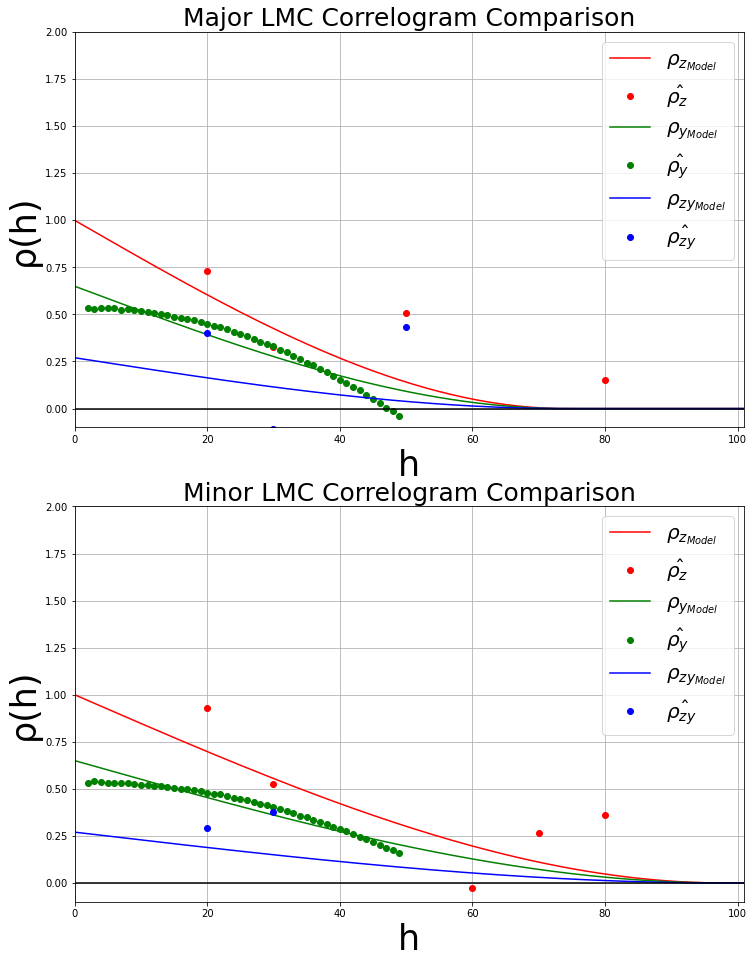

In [182]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{zy_{Model}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
nstruct = dict_secondary_LMC["nstruct"]
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary_LMC, nstruct )

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary_LMC, nstruct )

        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross_LMC, nstruct)

        H[h] = h
    MM_vargs = [cz_True, cy, czy]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" LMC Correlogram Comparison",
        size=25,y = 1
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

In [183]:
varc_3

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
1,20.0,3.0,0.051447,1.0
2,30.0,3.0,0.559429,1.0
4,50.0,2.0,0.015523,1.0
5,60.0,4.0,0.925716,1.0
6,70.0,4.0,1.831775,1.0
7,80.0,8.0,0.773284,1.0
8,90.0,2.0,1.530443,1.0
10,20.0,2.0,0.161562,2.0
11,30.0,2.0,0.075967,2.0
14,60.0,7.0,1.326240,2.0


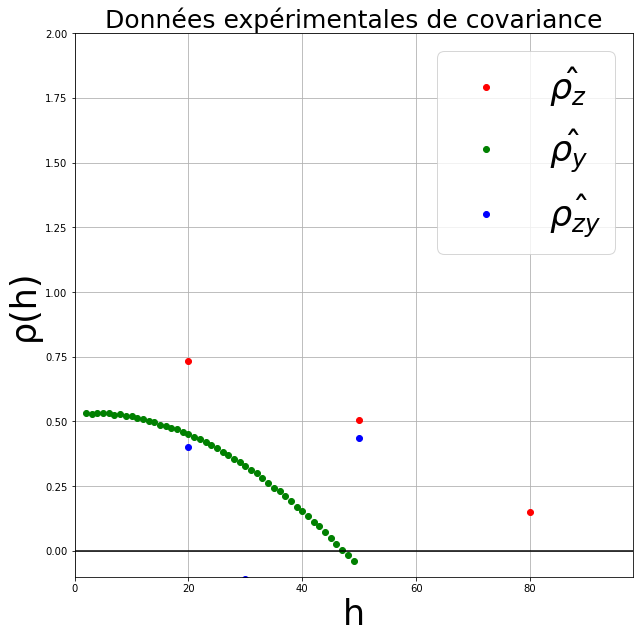

In [225]:
condition = True 
if condition :
    varg_type = 2  # See Correlogram Functions
    k = 0
    
    for Dir in ["Major,Minor"]:
        for h in range(0, 101):

            cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

            cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

            cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

            cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )
            
            czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
            
            H[h] = h
        MM_vargs = [cz_True, cy, czy]

    for Dir in ["Major,Minor"]:
        fig, axes = plt.subplots(1, 1, figsize=(10, 10))
        
        for i in range(0, 3):
            #axes.plot(H, MM_vargs[i], color=colors[i], label=labels_1[i])
            if (i + 1) < 4:
                var = locals()["varc_{}".format(i + 1)]
                axes.plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "o",
                    color=colors[i],
                    label=labels_1[i],
                )

        axes.plot(H, ones, color="Black")
        axes.grid()
        plt.xlim(0, 98)
        plt.ylim(-0.1, 2)
        plt.ylabel("\u03C1(h)", size=35)
        plt.xlabel("h", size=35)
        plt.title( "Données expérimentales de covariance",
            size=25,
        )
        axes.legend(loc="best", prop={"size": 35})
        plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
        varg_type = varg_type + 1

# Cokriging

In [227]:
Mean_Z = np.average(Primary["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

-2.2204460492503132e-17
1.0


In [228]:
Mean_Y = np.average(Primary["Secondary"])
STD_Y =  1.0
print(Mean_Y)
print(STD_Y)

1.1102230246251566e-17
1.0


## KDTree

In [229]:
from sklearn.neighbors import KDTree

In [230]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    
    return low_quality_secondary,x_ech,y_ech,z_ech

In [231]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
ech = 1
df_kriging,x_ech,y_ech,z_ech = ech_data_kdtree(x,y,z,ech)

In [232]:
Primary_dense = pd.DataFrame()
for column_name in Primary :
    if column_name == "X" or column_name == "Y" :
        column_data = Primary[column_name].values.tolist() * 10
        column_data = np.array(column_data) + np.linspace(0,0.01,len(column_data))
        column_data = column_data.tolist()
    else :
        column_data = Primary[column_name].values.tolist() * 10
        
    Primary_dense[column_name] = column_data
    
    
Primary_dense = Primary_dense.sort_values(by=['X', 'Y'])
Primary_dense = Primary_dense.reset_index(drop=True)
    
    

In [233]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary[["X", "Y"]].values
datafl = Primary
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

### Primary Data Search for Kriging

In [234]:
k_p = 10 # number of data to use
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["X", "Y"]]

### Secondary Data Search for Kriging

In [235]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

### Recap des models de variogrammes

In [236]:
print("Premier Correlogram") 
print(dict_primary)

Premier Correlogram
{'a_max': [150.0], 'a_min': [22.0], 'cc': [0.24], 'vtype': array([1]), 'nstruct': 1}


In [237]:
print("Second Correlogram") 
print(dict_secondary)

Second Correlogram
{'a_max': [63.0], 'a_min': [84.0], 'cc': [0.56], 'vtype': array([3]), 'nstruct': 1}


In [238]:
print("Cross Correlogram") 
print(dict_cross)

Cross Correlogram
{'a_max': [40.0], 'a_min': [30.0], 'cc': [0.14], 'vtype': array([1]), 'nstruct': 1}


In [239]:
print("LMC Correlogram ") 
print(dict_LMC)

LMC Correlogram 
{'a_max': [76.0], 'a_min': [99.0], 'vtype': array([1]), 'nstruct': 1}


## Simple Kriging

In [240]:
k = k_p
est_SK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k, k)))
    # h = distance_matrix(X_Y[z,:,:].tolist(),X_Y[z,:,:].tolist())
    # C_ZZ
    Kriging_Matrix = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 1, Azimuth = 0)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((k)),((k))))
    r = np.zeros(shape=(k))
    k_weights = r
    # RHS #C_z*
    r = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 1, Azimuth = 0 )
    Kriging_Matrix.reshape(((k)), ((k)))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_SK[z] = 0
    # add in mean_z
    est_SK[z] = est_SK[z] + Mean_Z
    for i in range(0, k):
        # add in Z_i
        est_SK[z] = est_SK[z] + k_weights[i] * (
            closematrix_Primary[z, i] - Mean_Z
        )

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1377.53it/s]


## Simple Cokriging

In [241]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 1, Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross, nstruct = 1, Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary, nstruct = 1, Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 1, Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross, nstruct = 1, Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 522.48it/s]

There where 0 Singular Matrices


## Simple Cokriging with LMC

In [242]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK_LMC = np.zeros(shape=(len(x)))
nstruct = dict_LMC["nstruct"]

dict_secondary_LMC
dict_primary_LMC
dict_cross_LMC

for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary_LMC, nstruct ,Azimuth = 0)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross_LMC, nstruct ,Azimuth = 0)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary_LMC, nstruct ,Azimuth = 0 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary_LMC, nstruct ,Azimuth = 0 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross_LMC, nstruct ,Azimuth = 0)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK_LMC[z] = 0
    # add in mean_z
    est_Full_CCK_LMC[z] = est_Full_CCK_LMC[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK_LMC[z] = (
            est_Full_CCK_LMC[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 511.72it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM2

In [243]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
        
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
    # C_ZY
    # 2,#3
    # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    czy = corr * C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # C_YY
    # 4
    # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 286.32it/s]

There where 0 Singular Matrices


##  Mise en place des résultats

In [244]:
ktypes = ["SK","SCK","LMC_SCK","ICCK_MM2"]
k_est = [est_SK,est_Full_CCK,
         est_Full_CCK_LMC,
         est_icck_MM2
]
ktypes_vals_dict = {}
dict_types = {}
j = 0
for i in ktypes:
    
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    
    df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]
    df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
    j = j + 1

##  Affichage des différents cokrigeage

In [245]:
dict_title = {}

In [246]:
## ICC_MM2
types = "ICCK_MM2"
# Title name Z / Y 
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
dict_title[types] = TITLE

In [247]:
## FCK
types = "SCK"
# Title name Z / Y / ZY

TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary["cc"])<2 or count == len(dict_primary["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary["cc"])<2) or (count == len(dict_secondary["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross["cc"])<2 or count == len(dict_cross["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
dict_title[types] = TITLE

In [248]:
## LMC_FCK
# Title name Z / Y / ZY
types = "LMC_SCK"
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary_LMC["cc"],dict_primary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_primary_LMC["cc"]) >= 2 ):
        a = 1
        TITLE += f"Z : {cc} {model} +" 
    elif len(dict_primary_LMC["cc"])<2 or count == len(dict_primary_LMC["cc"]) :
        TITLE += f"Z : {cc} {model} \n"
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_secondary_LMC["cc"],dict_secondary_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_secondary_LMC["cc"]) >= 2 ):
        TITLE += f"Y : {cc} {model} +" 
    elif (len(dict_secondary_LMC["cc"])<2) or (count == len(dict_secondary_LMC["cc"])):
        TITLE += f"Y : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
    
count = 1
for cc,vtype in zip(dict_cross_LMC["cc"],dict_cross_LMC["vtype"]) :
    model = MODEL_name[vtype]
    if (count == 1) & (len(dict_cross_LMC["cc"]) >= 2) :
        TITLE += f"ZY : {cc} {model} +" 
    elif len(dict_cross_LMC["cc"])<2 or count == len(dict_cross_LMC["cc"]):
        TITLE += f"ZY : {cc} {model} \n"                 
    else : 
        TITLE += f"{cc} {model} +"
    count += 1
dict_title[types] = TITLE

### MM2 vs SCK

KeyError: 'FCK'

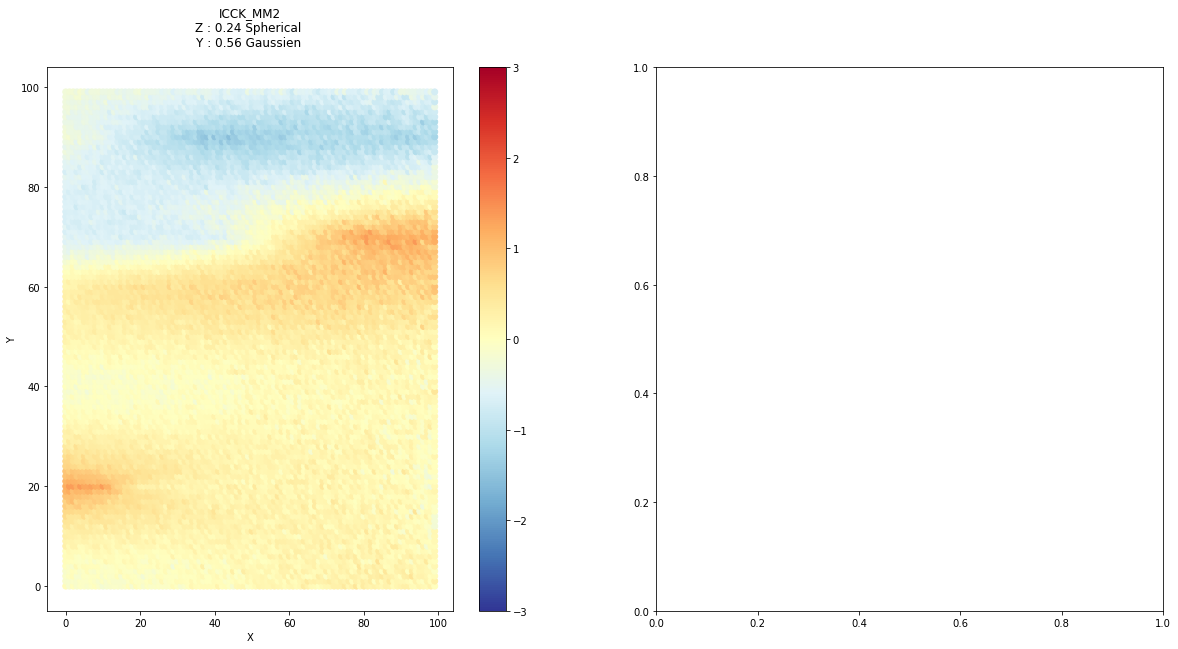

In [249]:
fig,ax=plt.subplots(1,2, figsize = (20,10))

types = "ICCK_MM2"
TITLE = dict_title[types]
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[0].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title(types +'\n'+TITLE, y = 1)
fig.colorbar(img0, ax=ax[0])

# ----------------------------------------------------------------------------------------------------------
types = "FCK"
TITLE = dict_title["FCK"]
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[1].scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
fig.colorbar(img0, ax=ax[1])
ax[1].set_title(types +'\n'+TITLE, y = 1)

### LMC

In [ ]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,1, figsize = (9,10))
types = "LMC_FCK"
TITLE = dict_title[types]

Z = df_kriging["NS_Estimate_"+types].values
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(img0, ax=ax)

ax.set_title(types +'\n'+TITLE, y = 1)

# Figure rapport

In [ ]:
fig,ax=plt.subplots(1,1, figsize = (9,10))

types = "ICCK_MM2"
TITLE = "Intrinsic Collocated Cokriging accompagné d'un model de Markov type 2 "
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax.set_xlabel('X', size = 17)
ax.set_ylabel('Y', size = 17)
ax.set_title(types +'\n'+TITLE, y = 1, size = 15)
cbar = fig.colorbar(img0, ax=ax)
cbar.set_label(label = "Données estimées normalisées", size = 22)

In [ ]:
fig,ax=plt.subplots(1,1, figsize = (9,10))

types = "LMC_SCK"
TITLE = "Simple Cokriging accompagné d'un LMC "
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax.set_xlabel('X', size = 17)
ax.set_ylabel('Y', size = 17)
ax.set_title(types +'\n'+TITLE, y = 1, size = 15)
cbar = fig.colorbar(img0, ax=ax)
cbar.set_label(label = "Données estimées normalisées", size = 22)

#  Comparaison des Cokriging à la fonction initiale 

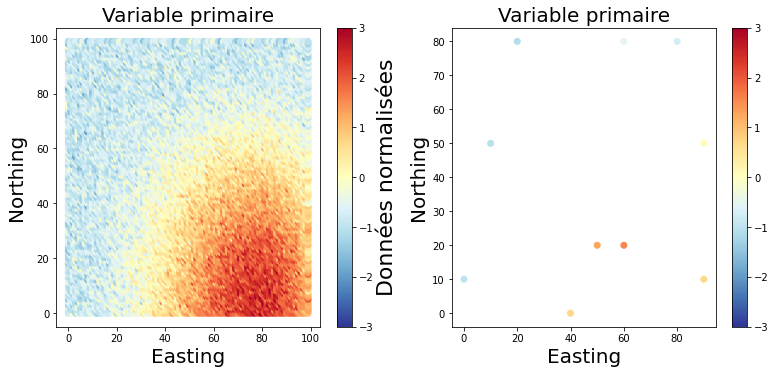

In [24]:
#Primary_truth Data Data
x, y = np.mgrid[0:0.5 * np.pi:100j, 0:0.5 * np.pi:100j]
np.random.seed(21)
mu, sigma = 0, 0.1
_field_z_truth  = fun_Primary(x,y,mu,sigma,size = 100)

Primary_truth = pd.DataFrame()
Primary_truth["X"] = xx_y.reshape(-1)
Primary_truth["Y"] = yy_y.reshape(-1)
Primary_truth["original_z"] = _field_z_truth.reshape(-1)
Primary_truth["Primary"] = (Primary_truth["original_z"] - Primary_truth["original_z"].mean()) / Primary_truth["original_z"].std()

fig, ax = plt.subplots(1,2, figsize=(13, 5.5))

img0 = ax[0].scatter(Primary_truth["X"], Primary_truth["Y"], c=Primary_truth["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[0].set_title("Variable primaire", size=20, y = 1)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
cbar = fig.colorbar(img0, ax=ax[0])
cbar.set_label(label = "Données normalisées", size = 22)

img0 = ax[1].scatter(Primary["X"], Primary["Y"], c=Primary["Primary"].values,
                     vmin = -3, vmax = 3, cmap = "RdYlBu_r")
ax[1].set_title("Variable primaire", size=20, y = 1)
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
fig.colorbar(img0, ax=ax[1])


### Différence entre LMC / fonction initiale

In [ ]:
df_kriging

In [ ]:
# Aperçu de la zone d'étude 
for types in ktypes :
    fig,ax=plt.subplots(1,1, figsize = (10,8))
    #Différence entre les valeurs originales et non transformées
    Z_ck = df_kriging["Estimate_"+types].values 
    Z_truth = Primary_truth["original_z"].values
    Z = Z_truth - Z_ck
    RMSE = np.sqrt(mean_squared_error(Z_ck,Z_truth))
    img0 = ax.scatter(x_ech, y_ech,c = Z,vmin = -1, vmax = 1, cmap = "seismic")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = fig.colorbar(img0, ax=ax)
    Title = "Différence entre les valeurs issus d'un cokriging " + types +" et de la fonction initiale \n RMSE = " + "{:.2f}".format(RMSE)
    ax.set_title(Title,size = 23, y = 1)
    cbar.set_label(label = "$Z_{Originale} - Z_{Prédite}$", size = 22)
    plt.show()